# WiDS Datathon 2024 Challenge #2

This Datathon used a real-world evidence dataset from Health Verity, one of the largest healthcare data ecosystems in the US.

**Task:** </br>
Predict the patient's Metastatic Diagnosis Period in the Test Dataset using the provided characteristics and information about the patient.

**Input data:** </br>
1) Training dataset `train.csv` where the observed values of the outcome [Metastatic Diagnosis Period] for each row is provided.
2) Test dataset `test.csv` where we withhold the observed values of the outcome for each row.
3) Example of a solution file prepared for submission in `solution_template.csv`.

**Additional facts about data:** </br>
— dataset contains health related information of patients who were diagnosed with *metastatic triple negative breast cancers* in US. </br>
— dataset was enriched with the US Zip Codes Database, </br>
— dataset was then further enriched with zip code level climate data. </br>

### Imports and data loading

In [456]:
# # Import and unzip datasets
# !kaggle competitions download -c widsdatathon2024-challenge2
# !unzip widsdatathon2024-challenge2.zip

In [517]:
# Import packages for data manipulation
import pandas as pd
import numpy as np
import re
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

from math import ceil
from scipy.stats import pearsonr, spearmanr, chi2_contingency, f_oneway, pointbiserialr


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# оценка метрик
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, silhouette_score


# modules and libraries for NLP processing the text data
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# Download NLTK data files for work with texts
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Ignore specific FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set values of the display option
pd.set_option("display.max_columns", 155)
pd.set_option("display.max_rows", 155)
pd.set_option("display.max_colwidth", 200)

[nltk_data] Downloading package punkt to /Users/ucyllama/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ucyllama/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ucyllama/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [458]:
# Load datasets into dataframe
df_solution = pd.read_csv("solution_template.csv")
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")

## Exploratory data analysis (EDA)

### Discovering
*Check out the overall shape, size, datatypes, Nulls and content of the datasets.*

#### Overview of the datasets

In [459]:
dataset_dict = {
    "test dataset": df_test,
    "training dataset": df_train,
    "solution template": df_solution
}

for table_name in dataset_dict:
    print(f'\n\n\033[1m{table_name.upper()}\033[0m')
    row, col = dataset_dict[table_name].shape
    print(f'The {table_name} contans \033[1m{row}\033[0m rows and \033[1m{col}\033[0m columns.')
    print('The first three rows of the table:')
    display(dataset_dict[table_name].head(3))

    dataset_dict[table_name].columns = [i.lower().replace(" ", "_").replace("-", "_") for i in dataset_dict[table_name].columns]
    
    print('Missing values:')
    df_info = pd.DataFrame(index=dataset_dict[table_name].columns)
    df_info["null_percent"] = round(100.0 * dataset_dict[table_name].isnull().sum() / row, 2)
    df_info["null_cnt"] = dataset_dict[table_name].isnull().sum()
    display(df_info.query("null_cnt > 0").sort_values(by="null_percent", ascending=False).transpose())

    print("Summary information: ")
    display(dataset_dict[table_name].info())



TEST DATASET
The test dataset contans 5646 rows and 151 columns.
The first three rows of the table:


patient_id patient_race  payer_type patient_state  patient_zip3 Region  \
0      730681          NaN  COMMERCIAL            LA           713  South   
1      334212        Black         NaN            NC           283  South   
2      571362          NaN  COMMERCIAL            TX           794  South   

             Division  patient_age patient_gender    bmi  \
0  West South Central           55              F    NaN   
1      South Atlantic           60              F  40.00   
2  West South Central           54              F  32.33   

  breast_cancer_diagnosis_code  \
0                         1746   
1                       C50912   
2                         1742   

                                   breast_cancer_diagnosis_desc  \
0          Malignant neoplasm of axillary tail of female breast   
1  Malignant neoplasm of unspecified site of left female breast   
2   Malignant neoplasm of upper-inner quadrant of female breast   

  metastatic_cancer_diagnosis_code metastatic_first_novel_treatment  \
0                            C7981                              NaN   
1                             C773                              NaN   
2                             C773                              NaN   

  metastatic_first_novel_treatment_type  population  density  age_median  \
0                                   NaN     4639.07    72.66       41.50   
1                                   NaN    10875.30   217.91       39.64   
2                                   NaN    18716.73  1019.51       30.37   

   age_under_10  age_10_to_19  age_20s  age_30s  age_40s  age_50s  age_60s  \
0         11.40         13.44    11.42    11.45    12.56    13.08    14.26   
1         11.23         13.72    15.01    12.02    11.58    11.77    12.77   
2         11.00         18.86    23.11    12.24     9.88     9.12     8.38   

   age_70s  age_over_80   male  female  married  divorced  never_married  \
0     7.71         4.73  50.02   49.98    42.37     14.70          34.76   
1     8.52         3.41  51.33   48.67    44.14     13.28          34.62   
2     4.78         2.62  50.29   49.71    35.99     12.76          46.65   

   widowed  family_size  family_dual_income  income_household_median  \
0     8.18         3.30               38.83                 40643.61   
1     7.96         3.33               42.57                 49924.38   
2     4.63         3.15               54.23                 48238.92   

   income_household_under_5  income_household_5_to_10  \
0                      6.77                      5.02   
1                      4.59                      3.83   
2                      6.12                      4.73   

   income_household_10_to_15  income_household_15_to_20  \
0                       9.93                       7.53   
1                       6.58                       5.27   
2                       6.70                       4.86   

   income_household_20_to_25  income_household_25_to_35  \
0                       6.36                      11.54   
1                       5.90                      13.16   
2                       6.21                      11.19   

   income_household_35_to_50  income_household_50_to_75  \
0                      12.60                      12.70   
1                      13.99                      18.14   
2                      13.28                      16.98   

   income_household_75_to_100  income_household_100_to_150  \
0                       11.60                         9.53   
1                       10.65                        11.39   
2                       10.42                        11.80   

   income_household_150_over  income_household_six_figure  \
0                       6.43                        15.97   
1                       6.49                        17.88   
2                       7.68                        19.48   

   income_individual_median  home_ownership  housing_units  home_value  \
0                  22663.32           74.7

Missing values:


metastatic_first_novel_treatment  \
null_percent                             99.88   
null_cnt                               5639.00   

              metastatic_first_novel_treatment_type     bmi  patient_race  \
null_percent                                  99.88    69.8         49.33   
null_cnt                                    5639.00  3941.0       2785.00   

              payer_type  average_of_apr_14  average_of_jun_14  \
null_percent        13.9               1.68                1.4   
null_cnt           785.0              95.00               79.0   

              average_of_oct_13  average_of_dec_18  average_of_mar_14  \
null_percent               0.48               0.41                0.3   
null_cnt                  27.00              23.00               17.0   

              average_of_jul_18  average_of_oct_17  average_of_aug_15  \
null_percent               0.28               0.27               0.27   
null_cnt                  16.00              15.00              15.00   

              average_of_sep_13  average_of_jul_17  average_of_apr_15  \
null_percent               0.25               0.23               0.18   
null_cnt                  14.00              13.00              10.00   

              average_of_nov_14  average_of_jan_13  average_of_nov_18  \
null_percent               0.16               0.16               0.14   
null_cnt                   9.00               9.00               8.00   

              average_of_jun_13  average_of_aug_18  average_of_mar_18  \
null_percent               0.12               0.12               0.12   
null_cnt                   7.00               7.00               7.00   

              average_of_feb_15  average_of_mar_15  average_of_feb_14  \
null_percent               0.11               0.11               0.11   
null_cnt                   6.00               6.00               6.00   

              average_of_feb_18  average_of_nov_17  average_of_aug_13  \
null_percent               0.11               0.11               0.09   
null_cnt                   6.00               6.00               5.00   

              average_of_dec_15  average_of_jun_18  average_of_may_16  \
null_percent               0.09               0.09               0.07   
null_cnt                   5.00               5.00               4.00   

              average_of_jul_16  average_of_feb_16  average_of_jan_16  \
null_percent               0.07               0.07               0.07   
null_cnt                   4.00               4.00               4.00   

              average_of_oct_15  average_of_nov_15  average_of_jan_17  \
null_percent               0.07               0.07               0.05   
null_cnt                   4.00               4.00               3.00   

              average_of_jan_14  average_of_jan_15  average_of_sep_17  \
null_percent               0.05               0.05               0.04   
null_cnt                   3.00               3.00               2.00   

              average_of_dec_16  average_of_sep_18  average_of_oct_18  \
null_percent               0.04               0.04               0.04   
null_cnt                   2.00               2.00               2.00   

              average_of_jun_17  
null_percent               0.02  
null_cnt                   1.00

Summary information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5646 entries, 0 to 5645
Columns: 151 entries, patient_id to average_of_dec_18
dtypes: float64(137), int64(3), object(11)
memory usage: 6.5+ MB


None



TRAINING DATASET
The training dataset contans 13173 rows and 152 columns.
The first three rows of the table:


patient_id patient_race  payer_type patient_state  patient_zip3   Region  \
0      268700          NaN  COMMERCIAL            AR           724    South   
1      484983        White         NaN            IL           629  Midwest   
2      277055          NaN  COMMERCIAL            CA           925     West   

             Division  patient_age patient_gender    bmi  \
0  West South Central           39              F    NaN   
1  East North Central           55              F  35.36   
2             Pacific           59              F    NaN   

  breast_cancer_diagnosis_code  \
0                       C50912   
1                       C50412   
2                         1749   

                                   breast_cancer_diagnosis_desc  \
0  Malignant neoplasm of unspecified site of left female breast   
1  Malig neoplasm of upper-outer quadrant of left female breast   
2            Malignant neoplasm of breast (female), unspecified   

  metastatic_cancer_diagnosis_code metastatic_first_novel_treatment  \
0                             C773                              NaN   
1                             C773                              NaN   
2                             C773                              NaN   

  metastatic_first_novel_treatment_type  population  density  age_median  \
0                                   NaN     3924.87    82.63       42.58   
1                                   NaN     2745.39    51.79       43.54   
2                                   NaN    38343.18   700.34       36.28   

   age_under_10  age_10_to_19  age_20s  age_30s  age_40s  age_50s  age_60s  \
0         11.61         13.03    10.87    11.80    12.29    13.22    13.47   
1         11.22         12.19    11.45    11.01    11.35    14.39    14.15   
2         13.27         15.66    13.49    13.45    12.40    11.58    10.47   

   age_70s  age_over_80   male  female  married  divorced  never_married  \
0    10.07         3.64  51.43   48.57    51.05     16.72          23.57   
1     9.17         5.05  49.32   50.68    49.48     15.42          26.93   
2     6.38         3.28  49.99   50.01    48.81     11.90          34.35   

   widowed  family_size  family_dual_income  income_household_median  \
0     8.66         3.01               43.99                 44483.35   
1     8.17         3.17               41.41                 51796.79   
2     4.95         3.80               52.89                 78696.87   

   income_household_under_5  income_household_5_to_10  \
0                      2.21                      3.97   
1                      3.67                      3.86   
2                      2.59                      1.81   

   income_household_10_to_15  income_household_15_to_20  \
0                       8.52                       7.08   
1                       6.58                       5.58   
2                       3.16                       3.71   

   income_household_20_to_25  income_household_25_to_35  \
0                       7.67                      13.82   
1                       5.38                      11.02   
2                       3.23                       7.40   

   income_household_35_to_50  income_household_50_to_75  \
0                      15.14                      17.51   
1                      13.09                      19.56   
2                      10.42                      16.83   

   income_household_75_to_100  income_household_100_to_150  \
0                       11.26                         8.90   
1                       11.76                        11.40   
2                       13.45                        19.21   

   income_household_150_over  income_household_six_figure  \
0                       3.93                        12.83   
1                       8.11                        19.51   
2                      18.23                        37.44   

   income_individual_median  home_ownership  housing_units  home_value  \
0                  24048.55       

Missing values:


metastatic_first_novel_treatment  \
null_percent                             99.92   
null_cnt                              13162.00   

              metastatic_first_novel_treatment_type      bmi  patient_race  \
null_percent                                  99.92    68.86         50.54   
null_cnt                                   13162.00  9071.00       6657.00   

              payer_type  average_of_apr_14  average_of_jun_14  \
null_percent        13.4               1.37               1.15   
null_cnt          1765.0             180.00             152.00   

              average_of_oct_13  average_of_jul_18  average_of_jan_13  \
null_percent               0.45               0.35               0.25   
null_cnt                  59.00              46.00              33.00   

              average_of_dec_18  average_of_jul_17  average_of_mar_14  \
null_percent               0.25               0.24               0.22   
null_cnt                  33.00              31.00              29.00   

              average_of_apr_15  average_of_sep_13  average_of_nov_14  \
null_percent               0.21                0.2               0.18   
null_cnt                  28.00               27.0              24.00   

              average_of_aug_15  average_of_oct_17  average_of_jun_13  \
null_percent               0.17               0.16               0.15   
null_cnt                  22.00              21.00              20.00   

              average_of_may_16  average_of_dec_15  average_of_aug_13  \
null_percent               0.14               0.14               0.13   
null_cnt                  19.00              18.00              17.00   

              average_of_jul_16  average_of_jan_16  average_of_feb_16  \
null_percent               0.12               0.12               0.12   
null_cnt                  16.00              16.00              16.00   

              average_of_nov_15  average_of_oct_15  average_of_aug_18  \
null_percent               0.12               0.12               0.12   
null_cnt                  16.00              16.00              16.00   

              average_of_dec_16  average_of_feb_15  average_of_mar_15  \
null_percent                0.1               0.09               0.09   
null_cnt                   13.0              12.00              12.00   

              average_of_nov_18  average_of_sep_17  average_of_jan_17  \
null_percent               0.09               0.08               0.07   
null_cnt                  12.00              10.00               9.00   

              average_of_feb_14  average_of_jun_18  average_of_jan_15  \
null_percent               0.07               0.07               0.05   
null_cnt                   9.00               9.00               6.00   

              average_of_mar_18  average_of_sep_18  average_of_oct_18  \
null_percent               0.05               0.05               0.05   
null_cnt                   6.00               7.00               7.00   

              average_of_nov_17  average_of_feb_18  family_size  \
null_percent               0.04               0.04         0.04   
null_cnt                   5.00               5.00         5.00   

              income_household_15_to_20  family_dual_income  \
null_percent                       0.04                0.04   
null_cnt                           5.00                5.00   

              income_household_20_to_25  poverty  income_household_six_figure  \
null_percent                       0.04     0.04                         0.04   
null_cnt                           5.00     5.00                         5.00   

              home_ownership  home_value  rent_median  rent_burden  \
null_percent            0.04        0.04         0.04         0.04   
null_cnt                5.00        5.00         5.00         5.00   

              self_employed  income_household_median  farmer  \
null_percent           0.04                     0.04    0.04   
null_cnt               5.00       

Summary information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13173 entries, 0 to 13172
Columns: 152 entries, patient_id to metastatic_diagnosis_period
dtypes: float64(137), int64(4), object(11)
memory usage: 15.3+ MB


None



SOLUTION TEMPLATE
The solution template contans 5646 rows and 2 columns.
The first three rows of the table:


patient_id  metastatic_diagnosis_period
0      730681                          100
1      334212                            0
2      571362                          100

Missing values:


Empty DataFrame
Columns: []
Index: [null_percent, null_cnt]

Summary information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5646 entries, 0 to 5645
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   patient_id                   5646 non-null   int64
 1   metastatic_diagnosis_period  5646 non-null   int64
dtypes: int64(2)
memory usage: 88.3 KB


None

In [460]:
duplicated_id = [i for i in df_test["patient_id"] if i in df_train["patient_id"].to_list()]
print(f"The number of duplicate patient_id for the test and training datasets: {len(duplicated_id)}")

The number of duplicate patient_id for the test and training datasets: 0


#### Geographical information
To make sure data on postal codes and regions is consistent and accurate, especially after adding regional demographics and climate information, it's important **to check that geographic details are the same in both test and train datasets**.

In [461]:
# Combine, deduplicate and reset the indexes for the test and train data
mask = ["patient_state", "patient_zip3", "region", "division", "population", "average_of_jan_18", "average_of_jun_15"]

zip_info =(
    pd.concat([df_test[mask], df_train[mask]])
    .drop_duplicates(ignore_index=True)
    .reset_index(drop=True)
)

display(zip_info.info())

print("List of states, regions, and divisions:")
display(zip_info[["patient_state", "region", "division"]].drop_duplicates().sort_values(["patient_state"]))

# Identify inconsistent zip codes
zip_bug = (
    zip_info[["patient_state", "patient_zip3", "region", "division"]]
    .groupby(["patient_zip3"])
    .nunique()
    .query("patient_state > 1 or region > 1 or division > 1")
    .reset_index()
)

print("Inconsistent Zip Codes:")
display(zip_bug)

# Display some metrics for those zip codes and states to identify the problem
# Note: 630 -> MO, 864 -> AZ
zip_list = [864, 630]
state_list = ["MO", "IL", "AZ", "CA"]

print("Metrics to check for an inconsistent pair of zip and state:")
display(
    zip_info
    .query("patient_zip3 in @zip_list")
    .drop_duplicates()
)

print("Median values for the states:")
display(
    zip_info[["patient_state", "population", "average_of_jan_18", "average_of_jun_15"]]
    .query("patient_state in @state_list")
    .groupby(["patient_state"])
    .median()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patient_state      768 non-null    object 
 1   patient_zip3       768 non-null    int64  
 2   region             768 non-null    object 
 3   division           768 non-null    object 
 4   population         768 non-null    float64
 5   average_of_jan_18  768 non-null    float64
 6   average_of_jun_15  768 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 42.1+ KB


None

List of states, regions, and divisions:


patient_state     region            division
654            AK       West             Pacific
264            AL      South  East South Central
160            AR      South  West South Central
37             AZ       West            Mountain
750            CA       West            Mountain
5              CA       West             Pacific
27             CO       West            Mountain
248            DC      South      South Atlantic
11             DE      South      South Atlantic
7              FL      South      South Atlantic
25             GA      South      South Atlantic
276            HI       West             Pacific
116            IA    Midwest  West North Central
15             ID       West            Mountain
21             IL    Midwest  East North Central
18             IN    Midwest  East North Central
54             KS    Midwest  West North Central
38             KY      South  East South Central
0              LA      South  West South Central
109            MD      South      South Atlantic
6              MI    Midwest  East North Central
16             MN    Midwest  West North Central
122            MO    Midwest  West North Central
60             MS      South  East South Central
13             MT       West            Mountain
1              NC      South      South Atlantic
595            ND    Midwest  West North Central
336            NE    Midwest  West North Central
42             NM       West            Mountain
246            NV       West            Mountain
19             NY  Northeast     Middle Atlantic
12             OH    Midwest  East North Central
35             OK      South  West South Central
252            OR       West             Pacific
9              PA  Northeast     Middle Atlantic
96             SC      South      South Atlantic
557            SD    Midwest  West North Central
3              TN      South  East South Central
2              TX      South  West South Central
186            UT       West            Mountain
64             VA      South      South Atlantic
4              WA       West             Pacific
72             WI    Midwest  East North Central
142            WV      South      South Atlantic
527            WY       West            Mountain

Inconsistent Zip Codes:


patient_zip3  patient_state  region  division
0           630              2       1         2
1           864              2       1         1

Metrics to check for an inconsistent pair of zip and state:


patient_state  patient_zip3   region            division  population  \
236            MO           630  Midwest  West North Central    12912.19   
438            AZ           864     West            Mountain     8967.22   
709            IL           630  Midwest  East North Central    12912.19   
750            CA           864     West            Mountain     8967.22   

     average_of_jan_18  average_of_jun_15  
236              27.53              73.72  
438              56.96              92.34  
709              27.53              73.72  
750              56.96              92.34

Median values for the states:


population  average_of_jan_18  average_of_jun_15
patient_state                                                  
AZ               9277.240             53.360             81.870
CA              26093.925             55.820             70.010
IL               4894.605             23.735             70.375
MO               3937.410             27.980             74.140

Looks like a problem not in the zip codes, but the `patient_state` and `division` columns were applied incorrectly.

#### Climate information

In [462]:
# Create a DataFrame with Monthly Average Temperature for zip-code
WEATHER_COL = [i for i in df_train.columns if re.match(r"^average_of|patient_z", i) != None]

weather_dt = (
    pd.concat([df_test[WEATHER_COL], df_train[WEATHER_COL]])
    .drop_duplicates(ignore_index=True)
    .reset_index(drop=True)
)

# Create a mask for missing values
mask = weather_dt.isna()
zip_weather_null = weather_dt.loc[mask.any(axis=1)]["patient_zip3"]

print(
    "Zip codes with missing climate data: {} ({}%)"
    .format(
        len(zip_weather_null), 
        round(100*len(zip_weather_null)/len(df_test["patient_zip3"]), 2)
    )
)

print(
    "Percentage of missing climate data in the training dataset: {}%"
    .format(round(len(df_train.query("patient_zip3 in @zip_weather_null"))/len(df_train["patient_zip3"])*100, 2))
)

print(
    "Percentage of missing climate data in the test dataset: {}%"
    .format(round(len(df_test.query("patient_zip3 in @zip_weather_null"))/len(df_test["patient_zip3"])*100, 2))
)

Zip codes with missing climate data: 29 (0.51%)
Percentage of missing climate data in the training dataset: 3.08%
Percentage of missing climate data in the test dataset: 3.45%


#### Social, demographic and economic information

In [463]:
exp = r"^((?!patient|payer|bmi|breast|meta|region|division|average)|patient_z)"

SOCIAL_COL = [i for i in df_train.columns if re.match(exp, i) != None]

social_dt = (
    pd.concat([df_test[SOCIAL_COL], df_train[SOCIAL_COL]])
    .drop_duplicates(ignore_index=True)
    .reset_index(drop=True)
)

print("General information:")
print(
    "Unique amount of zip codes: {} ({} total rows)."
    .format(
        pd.concat([df_test, df_train])["patient_zip3"].nunique()
        , len(social_dt["patient_zip3"])
    )
)

social_zip_bug = (
    social_dt
    .groupby(["patient_zip3"], as_index=False)
    .count()
    .query('population > 1')['patient_zip3']
    .to_list()
)
print(f"\nZip codes with inconcistent information: \n{social_zip_bug}")

print("\nMetrics to look for a possible problem: ")
population_list = social_dt.query("patient_zip3 in @social_zip_bug")["population"].to_list()
display(social_dt.query("population in @population_list").sort_values(["patient_zip3"]))

print(
    "Percentage of inconcistent social data in the training dataset: {}%"
    .format(round(len(df_train.query("patient_zip3 in @social_zip_bug"))/len(df_train["patient_zip3"])*100, 2))
)

print(
    "Percentage of inconcistent social data in the test dataset: {}%"
    .format(round(len(df_test.query("patient_zip3 in @social_zip_bug"))/len(df_test["patient_zip3"])*100, 2))
)

General information:
Unique amount of zip codes: 763 (766 total rows).

Zip codes with inconcistent information: 
[395, 968, 988]

Metrics to look for a possible problem: 


patient_zip3  population  density  age_median  age_under_10  \
298           394    10492.25    90.65       39.06         12.29   
433           395    14629.18   275.45       38.94         10.93   
712           395    10492.25    90.65       39.06         12.29   
536           968    21581.45  2693.96       36.28          6.11   
700           968    13697.21   475.67       43.13         10.43   
351           970    13697.21   475.67       43.13         10.43   
521           986    11511.37   282.92       46.43          9.92   
328           988     5322.18    22.96       44.75         10.57   
755           988    11511.37   282.92       46.43          9.92   

     age_10_to_19  age_20s  age_30s  age_40s  age_50s  age_60s  age_70s  \
298         14.07    14.18    11.76    11.30    12.18    12.72     7.69   
433         13.81    15.54    12.69    11.60    12.71    11.51     7.94   
712         14.07    14.18    11.76    11.30    12.18    12.72     7.69   
536         10.99    36.90    10.54     8.52     8.75     8.44     5.56   
700         12.62    10.47    13.35    11.47    14.15    13.95     9.32   
351         12.62    10.47    13.35    11.47    14.15    13.95     9.32   
521         10.45    10.23    11.84    11.19    14.09    17.29    10.17   
328         13.01    10.87    10.51    11.90    13.02    16.85     9.35   
755         10.45    10.23    11.84    11.19    14.09    17.29    10.17   

     age_over_80   male  female  married  divorced  never_married  widowed  \
298         3.83  48.95   51.05    48.77     13.15          30.01     8.09   
433         3.23  52.56   47.44    44.20     15.83          33.72     6.25   
712         3.83  48.95   51.05    48.77     13.15          30.01     8.09   
536         4.16  61.60   38.40    33.07      7.68          54.98     4.28   
700         4.25  51.12   48.88    52.68     15.63          26.99     4.70   
351         4.25  51.12   48.88    52.68     15.63          26.99     4.70   
521         4.83  50.19   49.82    55.76     14.39          23.02     6.82   
328         3.90  49.99   50.01    54.37     15.16          25.44     5.03   
755         4.83  50.19   49.82    55.76     14.39          23.02     6.82   

     family_size  family_dual_income  income_household_median  \
298         3.28               42.89                 47510.59   
433         3.13               45.52                 52793.96   
712         3.28               42.89                 47510.59   
536         3.24               58.06                 89923.64   
700         3.06               51.96                 77232.94   
351         3.06               51.96                 77232.94   
521         2.91               45.74                 71508.87   
328         3.02               48.72                 60952.27   
755         2.91               45.74                 71508.87   

     income_household_under_5  income_household_5_to_10  \
298                      3.79                      4.57   
433                      4.37                      3.24   
712                      3.79                      4.57   
536                      3.16                      2.27   
700                      2.12                      1.53   
351                      2.12                      1.53   
521                      2.74                      1.83   
328                      1.83                      2.52   
755                      2.74                      1.83   

     income_household_10_to_15  income_household_15_to_20  \
298                       6.86                       6.27   
433                       4.94                       5.92   
712                       6.86                       6.27   
536                       2.60                       2.55   
700                       2.92                       2.98   
351                       2.92                       2.98   
521                       4.45                       3.28   
328                       4.00                       3.41   
7

Percentage of inconcistent social data in the training dataset: 0.23%
Percentage of inconcistent social data in the test dataset: 0.19%


*Looks like some of the data were taken from neighbouring zip codes (394, 970, 986).*

In [464]:
# Create a mask for missing values
mask = social_dt.isna()
zip_social_null = social_dt.loc[mask.any(axis=1)]["patient_zip3"].to_list()

print(f"Zip codes with missing social data: \n{zip_social_null}\n")
print(
    "Amount of missing social data in the training dataset: {} ({}%)"
    .format(
        len(df_train.query("patient_zip3 in @zip_social_null"))
        , round(len(df_train.query("patient_zip3 in @zip_social_null"))/len(df_train["patient_zip3"])*100, 2)
    )
)

print(
    "Amount of missing social data in the test dataset: {} ({}%)"
    .format(
        len(df_test.query("patient_zip3 in @zip_social_null"))
        , round(len(df_test.query("patient_zip3 in @zip_social_null"))/len(df_test["patient_zip3"])*100, 2)
    )
)


Zip codes with missing social data: 
[772]

Amount of missing social data in the training dataset: 5 (0.04%)
Amount of missing social data in the test dataset: 0 (0.0%)


#### Breast Cancer Diagnosis types and codes

In [465]:
col = ["breast_cancer_diagnosis_code", "breast_cancer_diagnosis_desc"] #"metastatic_cancer_diagnosis_code"

# create a dictionary with all unique types of diagnoses
breast_cancer_diagnosis = (
    pd.concat([df_test[col], df_train[col]])
    .drop_duplicates()
    .reset_index(drop=True)
)


# Cleaning data using NLP techniques and NLTK library
def clean_str(text):
    # Normalise the text and remove punctuation
    text = (
        text
        .lower()
        .translate(str.maketrans('', '', string.punctuation))
    )
    # Tokenise the text
    tokens = word_tokenize(text)
    # Remove "stop" words
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    # Lemmatise tokens to ensure consistency
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    # Save information in string format
    text = ' '.join(tokens)
    text = text.replace("malignant", "malig")
    text = text.replace("neoplasm", "neoplm")

    return text


def diagnosis_gender(text):
    if 'female' in text:
        return 'F'
    elif 'male' in text:
        return 'M'
    else:
        return 'unspecified'


breast_cancer_diagnosis["breast_cancer_diagnosis_desc_cleaned"] = breast_cancer_diagnosis["breast_cancer_diagnosis_desc"].apply(clean_str)
breast_cancer_diagnosis["gender"] = breast_cancer_diagnosis["breast_cancer_diagnosis_desc_cleaned"].apply(diagnosis_gender)

print("Amount of unique values:")
display(breast_cancer_diagnosis.nunique())

# Check unexpected Breast Cancer Diagnosis codes in test and train datasets
print("Unexpected Breast Cancer Diagnosis codes:")
display(breast_cancer_diagnosis.query('gender != "F"'))

wrong_codes = breast_cancer_diagnosis.query('gender != "F"')["breast_cancer_diagnosis_code"].to_list()
test_wrong_code_df = df_test.query('breast_cancer_diagnosis_code in @wrong_codes')
train_wrong_code_df = df_train.query('breast_cancer_diagnosis_code in @wrong_codes')
print(
    "Amount of patients in trainig dataset with unexpected Breast Cancer Diagnosis code: {} ({:.3f}%)"
    .format(len(train_wrong_code_df["patient_id"]), len(train_wrong_code_df["patient_id"])/len(df_train["patient_id"]))
)
display(train_wrong_code_df.sort_values(["breast_cancer_diagnosis_code"]))
print(
    "Amount of patients in testing dataset with unexpected Breast Cancer Diagnosis code: {} ({:.3f}%)"
    .format(len(test_wrong_code_df["patient_id"]), len(test_wrong_code_df["patient_id"])/len(df_test["patient_id"]))
)
display(test_wrong_code_df.sort_values(["breast_cancer_diagnosis_code"]))

Amount of unique values:


breast_cancer_diagnosis_code            48
breast_cancer_diagnosis_desc            48
breast_cancer_diagnosis_desc_cleaned    48
gender                                   3
dtype: int64

Unexpected Breast Cancer Diagnosis codes:


breast_cancer_diagnosis_code  \
11                        19881   
41                       C50421   
42                       C50922   
44                       C50221   
45                         C509   
46                       C50122   

                                   breast_cancer_diagnosis_desc  \
11                       Secondary malignant neoplasm of breast   
41  Malig neoplasm of upper-outer quadrant of right male breast   
42   Malignant neoplasm of unspecified site of left male breast   
44  Malig neoplasm of upper-inner quadrant of right male breast   
45             Malignant neoplasm of breast of unspecified site   
46    Malignant neoplasm of central portion of left male breast   

                  breast_cancer_diagnosis_desc_cleaned       gender  
11                       secondary malig neoplm breast  unspecified  
41  malig neoplm upperouter quadrant right male breast            M  
42      malig neoplm unspecified site left male breast            M  
44  malig neoplm upperinner quadrant right male breast            M  
45                malig neoplm breast unspecified site  unspecified  
46       malig neoplm central portion left male breast            M

Amount of patients in trainig dataset with unexpected Breast Cancer Diagnosis code: 20 (0.002%)


patient_id patient_race          payer_type patient_state  \
148        591124        White            MEDICAID            FL   
347        973960        White            MEDICAID            GA   
1057       537689        White  MEDICARE ADVANTAGE            FL   
1784       323996          NaN          COMMERCIAL            CA   
1803       736575          NaN            MEDICAID            CA   
11073      171323          NaN            MEDICAID            CA   
2281       694500          NaN  MEDICARE ADVANTAGE            NY   
11373      943003     Hispanic            MEDICAID            AZ   
3494       594180          NaN          COMMERCIAL            TX   
3824       994669          NaN            MEDICAID            GA   
4630       628621          NaN          COMMERCIAL            MO   
6578       404019        Black  MEDICARE ADVANTAGE            CA   
6184       222796        White            MEDICAID            CA   
3008       119773          NaN                 NaN            CA   
712        133511          NaN          COMMERCIAL            PA   
7440       724607          NaN          COMMERCIAL            NY   
3424       534306          NaN          COMMERCIAL            NY   
5359       670283        White          COMMERCIAL            CA   
12812      466431          NaN          COMMERCIAL            NY   
1908       141903        Other            MEDICAID            FL   

       patient_zip3     region            division  patient_age  \
148             339      South      South Atlantic           67   
347             317      South      South Atlantic           62   
1057            329      South      South Atlantic           66   
1784            908       West             Pacific           73   
1803            900       West             Pacific           82   
11073           928       West             Pacific           82   
2281            100  Northeast     Middle Atlantic           82   
11373           856       West            Mountain           58   
3494            778      South  West South Central           82   
3824            317      South      South Atlantic           53   
4630            631    Midwest  West North Central           68   
6578            900       West             Pacific           68   
6184            913       West             Pacific           49   
3008            900       West             Pacific           53   
712             173  Northeast     Middle Atlantic           45   
7440            104  Northeast     Middle Atlantic           48   
3424            100  Northeast     Middle Atlantic           61   
5359            945       West             Pacific           48   
12812           105  Northeast     Middle Atlantic           57   
1908            330      South      South Atlantic           66   

      patient_gender    bmi breast_cancer_diagnosis_code  \
148                F    NaN                        19881   
347                F    NaN                        19881   
1057               F    NaN                        19881   
1784               F    NaN                        19881   
1803               F  31.00                        19881   
11073              F    NaN                        19881   
2281               F    NaN                        19881   
11373              F  23.63                        19881   
3494               F  31.62                        19881   
3824               F    NaN                        19881   
4630               F    NaN                        19881   
6578               F    NaN                        19881   
6184               F    NaN                       C50122   
3008               F    NaN                       C50221   
712                F    NaN                       C50421   
7440               F    NaN                         C509   
3424               F    NaN                         C509   
5359               F    NaN                         C509   
12812              F    NaN   

Amount of patients in testing dataset with unexpected Breast Cancer Diagnosis code: 7 (0.001%)


patient_id patient_race          payer_type patient_state  patient_zip3  \
12        832804        White  MEDICARE ADVANTAGE            OH           442   
87        544670          NaN  MEDICARE ADVANTAGE            MN           551   
92        958647        Black            MEDICAID            PA           180   
3084      891357        Other          COMMERCIAL            CA           925   
3318      234959        White            MEDICAID            IL           604   
4343      388935        White          COMMERCIAL            MI           482   
4988      299224        Black  MEDICARE ADVANTAGE            CA           946   

         region            division  patient_age patient_gender    bmi  \
12      Midwest  East North Central           82              F    NaN   
87      Midwest  West North Central           65              F  35.48   
92    Northeast     Middle Atlantic           56              F  28.90   
3084       West             Pacific           62              F    NaN   
3318    Midwest  East North Central           67              F  26.04   
4343    Midwest  East North Central           46              F    NaN   
4988       West             Pacific           76              F  26.97   

     breast_cancer_diagnosis_code            breast_cancer_diagnosis_desc  \
12                          19881  Secondary malignant neoplasm of breast   
87                          19881  Secondary malignant neoplasm of breast   
92                          19881  Secondary malignant neoplasm of breast   
3084                        19881  Secondary malignant neoplasm of breast   
3318                        19881  Secondary malignant neoplasm of breast   
4343                        19881  Secondary malignant neoplasm of breast   
4988                        19881  Secondary malignant neoplasm of breast   

     metastatic_cancer_diagnosis_code metastatic_first_novel_treatment  \
12                              C7951                              NaN   
87                              C7981                              NaN   
92                              C7951                              NaN   
3084                             C786                              NaN   
3318                            C7981                              NaN   
4343                            C7981                              NaN   
4988                            C7981                              NaN   

     metastatic_first_novel_treatment_type  population  density  age_median  \
12                                     NaN    13035.00   355.70       42.89   
87                                     NaN    25588.25  1359.15       38.29   
92                                     NaN    10226.53   452.83       43.55   
3084                                   NaN    38343.18   700.34       36.28   
3318                                   NaN    18355.10   901.20       39.77   
4343                                   NaN    22080.59  1666.52       36.59   
4988                                   NaN    30600.00  3807.06       36.28   

      age_under_10  age_10_to_19  age_20s  age_30s  age_40s  age_50s  age_60s  \
12           10.60         14.09    11.44    11.42    11.43    14.90    13.55   
87           11.99         12.06    14.19    14.52    11.20    13.42    13.36   
92            9.94         13.41    10.48    10.89    14.10    14.54    13.62   
3084         13.27         15.66    13.49    13.45    12.40    11.58    10.47   
3318         11.67         14.25    12.34    12.34    12.92    13.67    12.40   
4343         12.78         12.86    15.81    13.20    11.89    12.46    11.60   
4988          9.95         13.17    16.11    18.63    13.12    10.87     9.47   

      age_70s  age_over_80   male  female  married  divorced  never_married  \
12       8.58         4.00  49.93   50.07    54.13     12.06          27.85   
87       6.01         3.25  50.57   49.43    45.30     11.19          39.23   
92       8.84         4.16  49.60  

#### Discovering: key takeaways
**Datasets have three types of features:**
1) Personal information about the patient: `patient_id`, `patient_race`, `payer_type`, `patient_age`, `patient_gender`, `bmi`, `breast_cancer_diagnosis_code`, `breast_cancer_diagnosis_desc`, `metastatic_cancer_diagnosis_code`, `metastatic_first_novel_treatment`, `metastatic_first_novel_treatment_type`. 
    - Plus geo-data: `patient_zip3`, `patient_state`, `region`, `division`.
2) Weather: Monthly mean temperature (72 columns, `Average of Jan-13`-`Average of Dec-18`).
3) Social economic information in the region: `population`, `density`, `age_median`, statistics by gender, marital status and family size, income, housing, education, race, age, employment type, `limited_english`, `commute_time`, `health_uninsured`.
 
</br>

**Both training and test datasets have a similar amount of missing data:**  
- About **99.9%** in `metastatic_first_novel_treatment_type` and `metastatic_first_novel_treatment`.
- About **69-70%** in `bmi`. There are also outliners in training dataset(BMI over 50).
- About **50-50.5%** in `patient_race`.
- About **13-14%** for `payer_type`.  
- About 1% and less for some of the weather and regional attributes.
    - Zip codes with missing climate data: 29 (0.51%)
        - Percentage of rows with missing climate data in the training dataset: 3.08%
        - Percentage of rows with missing climate data in the test dataset: 3.45%
    - Part of social, demographic and economic information has been incorrectly applied to some postcodes: 395, 968, 988.
        - Percentage of inconcistent social data in the training dataset: 0.23%
        - Percentage of inconcistent social data in the test dataset: 0.19%
        - Amount of missing data in the training dataset: 5 (0.04%)
        - Amount of missing data in the test dataset: 0 (0.0%)
- There are also inconsistencies for two zip-codes where the `patient_state` and `division` appear to be wrong: 
    - 630 -> MO and West North Central `division` (not IL and East North Central), 
    - 864 -> AZ (not CA). 
- Datasets contains only femal data (`patient_gender` == 'F')
- Breast cancer diagnosis contains unexpected codes related to male and unspecified cancers:
    - 0.002% of training dataset and 0.001% of testing,
    - Male specific codes are only present in the training dataset: C50421, C50922, C50221 and C50122,
    - Unspecified code C509 present only in training data set,
    - Unspecified code 19881 present in both training and test data sets.

### Structuring and pre-cleaning
Turn data into different segments and time periods to understand trends.

#### Dictionaries

1. Create a dictionary with general geographical data:

In [466]:
col_list = ["patient_zip3", "patient_state", "region", "division"]
# Create the mask
condition_1 = (zip_info["patient_zip3"] == 630) & (zip_info["patient_state"] != "MO")
condition_2 = (zip_info["patient_zip3"] == 864) & (zip_info["patient_state"] != "AZ")
mask = ~(condition_1 | condition_2)

# Apply the mask and filter
zip_region_dict = zip_info.loc[mask, col_list].drop_duplicates().copy()

# Create new columns with numerical values
for col in col_list:
    col_name = col + "_num"
    zip_region_dict[col_name] = pd.factorize(zip_region_dict[col])[0]

# Display the descriptive statistics of the filtered dataframe
print("General information for the filtered zip codes:\n")
print(zip_region_dict.info())

# Display the filtered dataset
print("\nFiltered data (first 15 rows):")
display(zip_region_dict.head(15))

General information for the filtered zip codes:

<class 'pandas.core.frame.DataFrame'>
Index: 763 entries, 0 to 767
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   patient_zip3       763 non-null    int64 
 1   patient_state      763 non-null    object
 2   region             763 non-null    object
 3   division           763 non-null    object
 4   patient_zip3_num   763 non-null    int64 
 5   patient_state_num  763 non-null    int64 
 6   region_num         763 non-null    int64 
 7   division_num       763 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 53.6+ KB
None

Filtered data (first 15 rows):


patient_zip3 patient_state     region            division  \
0            713            LA      South  West South Central   
1            283            NC      South      South Atlantic   
2            794            TX      South  West South Central   
3            373            TN      South  East South Central   
4            980            WA       West             Pacific   
5            914            CA       West             Pacific   
6            483            MI    Midwest  East North Central   
7            336            FL      South      South Atlantic   
8            917            CA       West             Pacific   
9            160            PA  Northeast     Middle Atlantic   
10           774            TX      South  West South Central   
11           199            DE      South      South Atlantic   
12           442            OH    Midwest  East North Central   
13           591            MT       West            Mountain   
14           440            OH    Midwest  East North Central   

    patient_zip3_num  patient_state_num  region_num  division_num  
0                  0                  0           0             0  
1                  1                  1           0             1  
2                  2                  2           0             0  
3                  3                  3           0             2  
4                  4                  4           1             3  
5                  5                  5           1             3  
6                  6                  6           2             4  
7                  7                  7           0             1  
8                  8                  5           1             3  
9                  9                  8           3             5  
10                10                  2           0             0  
11                11                  9           0             1  
12                12                 10           2             4  
13                13                 11           1             6  
14                14                 10           2             4

2. Create a dictionary of general socio-economic data:
- Remove the 772 postcode because it has missing data (0.04% of the training dataset) and it won't affect the test dataset.
- Remove incorrect data for 395, 968, 988 zip codes.

In [467]:
# Create the mask
condition_1 = (social_dt["patient_zip3"] == 395) & (social_dt["population"] == 10492.25)
condition_2 = (social_dt["patient_zip3"] == 968) & (social_dt["population"] == 13697.21)
condition_3 = (social_dt["patient_zip3"] == 988) & (social_dt["population"] == 11511.37)
condition_4 = (social_dt["patient_zip3"] == 772)
mask = ~(condition_1 | condition_2| condition_3| condition_4)

# Apply the mask and filter
social_metrics_dict = social_dt.loc[mask].drop_duplicates().copy()

display(social_metrics_dict.describe())


patient_zip3    population       density  age_median  age_under_10  \
count    762.000000    762.000000    762.000000  762.000000    762.000000   
mean     528.931759  11948.764173    706.197047   42.004606     10.907060   
std      260.081551  10699.089232   1878.476827    4.342811      1.717174   
min      100.000000    635.550000      0.920000   30.030000      5.220000   
25%      302.250000   3721.717500     48.647500   39.135000      9.762500   
50%      511.500000   7784.895000    159.990000   42.370000     10.860000   
75%      753.500000  18022.360000    694.145000   44.750000     12.045000   
max      997.000000  71374.130000  29851.690000   54.570000     17.680000   

       age_10_to_19     age_20s     age_30s     age_40s     age_50s  \
count    762.000000  762.000000  762.000000  762.000000  762.000000   
mean      12.843976   12.380958   11.816719   11.596430   13.694685   
std        2.234487    3.583107    2.133828    1.380767    1.880760   
min        6.310000    5.930000    5.690000    7.060000    7.990000   
25%       11.560000   10.230000   10.475000   10.690000   12.580000   
50%       12.765000   11.435000   11.440000   11.620000   13.745000   
75%       13.852500   13.480000   12.690000   12.470000   14.777500   
max       27.530000   36.900000   25.470000   17.820000   21.660000   

          age_60s     age_70s  age_over_80        male      female  \
count  762.000000  762.000000   762.000000  762.000000  762.000000   
mean    13.825892    8.565328     4.370249   50.370105   49.630262   
std      2.857241    2.383546     1.473899    1.927568    1.927717   
min      6.900000    3.970000     1.370000   39.730000   38.400000   
25%     11.920000    6.865000     3.470000   49.292500   48.592500   
50%     13.695000    8.370000     4.220000   50.315000   49.685000   
75%     15.547500    9.815000     4.937500   51.407500   50.707500   
max     24.510000   19.000000    18.830000   61.600000   60.280000   

          married    divorced  never_married     widowed  family_size  \
count  762.000000  762.000000     762.000000  762.000000   762.000000   
mean    49.356522   13.235499      30.728583    6.679869     3.138609   
std      7.468706    2.277938       7.999855    1.933735     0.221079   
min     26.240000    5.230000      13.440000    2.570000     2.550000   
25%     44.840000   11.792500      25.005000    5.350000     2.990000   
50%     50.950000   13.360000      28.190000    6.485000     3.100000   
75%     54.640000   14.737500      34.817500    7.750000     3.250000   
max     66.900000   21.030000      61.800000   20.650000     4.170000   

       family_dual_income  income_household_median  income_household_under_5  \
count          762.000000               762.000000                762.000000   
mean            49.146811             65777.998058                  3.320105   
std              7.878215             19603.362534                  1.556130   
min             19.310000             29222.000000                  0.750000   
25%             43.437500             53418.375000                  2.262500   
50%             49.605000             62044.955000                  2.955000   
75%             54.767500             72012.005000                  4.027500   
max             65.640000            164119.200000                 19.620000   

       income_household_5_to_10  income_household_10_to_15  \
count                762.000000                 762.000000   
mean                   2.823255                   4.657979   
std                    1.504856                   1.936767   
min                    0.360000                   1.020000   
25%                    1.800000                   3.350000   
50%                    2.430000                   4.330000   
75%                    3.507500                   5.690000   
max                   11.870000                  14.280000   

       income_household_15_to_20  income_household_20_to_25  \
count                 762.000000         

3. Breast cancer diagnosis dictionary

In [468]:
# Create the mask
mask = (breast_cancer_diagnosis["gender"] != 'M') & (breast_cancer_diagnosis["breast_cancer_diagnosis_code"] != 'C509')


breast_cancer_diagnosis_dict = (
    breast_cancer_diagnosis
    .loc[mask][["breast_cancer_diagnosis_code", "breast_cancer_diagnosis_desc_cleaned"]]
    .reset_index(drop=True)
    .rename(columns={"breast_cancer_diagnosis_desc_cleaned": "breast_cancer_diagnosis_desc"})
)

display(breast_cancer_diagnosis_dict)

breast_cancer_diagnosis_code  \
0                          1746   
1                        C50912   
2                          1742   
3                          1748   
4                        C50411   
5                          1749   
6                        C50911   
7                        C50919   
8                        C50011   
9                        C50812   
10                       C50112   
11                        19881   
12                       C50811   
13                         1744   
14                       C50212   
15                       C50412   
16                       C50211   
17                       C50111   
18                       C50311   
19                       C50219   
20                       C50512   
21                         1745   
22                       C50419   
23                         1741   
24                        C5021   
25                       C50312   
26                       C50819   
27                       C50511   
28                       C50611   
29                       C50012   
30                         1743   
31                       C50612   
32                       C50119   
33                        C5041   
34                       C50519   
35                        C5091   
36                       C50019   
37                        C5011   
38                        C5081   
39                        C5031   
40                       C50319   
41                        C5001   
42                       C50619   

                            breast_cancer_diagnosis_desc  
0               malig neoplm axillary tail female breast  
1       malig neoplm unspecified site left female breast  
2         malig neoplm upperinner quadrant female breast  
3              malig neoplm specified site female breast  
4   malig neoplm upperouter quadrant right female breast  
5                 malig neoplm breast female unspecified  
6             malig neoplm unsp site right female breast  
7       malig neoplm unsp site unspecified female breast  
8         malig neoplm nipple areola right female breast  
9             malig neoplm ovrlp site left female breast  
10       malig neoplm central portion left female breast  
11                         secondary malig neoplm breast  
12           malig neoplm ovrlp site right female breast  
13        malig neoplm upperouter quadrant female breast  
14   malig neoplm upperinner quadrant left female breast  
15   malig neoplm upperouter quadrant left female breast  
16  malig neoplm upperinner quadrant right female breast  
17      malig neoplm central portion right female breast  
18  malig neoplm lowerinner quadrant right female breast  
19   malig neoplm upperinner quadrant unsp female breast  
20   malig neoplm lowerouter quadrant left female breast  
21        malig neoplm lowerouter quadrant female breast  
22   malig neoplm upperouter quadrant unsp female breast  
23            malig neoplm central portion female breast  
24        malig neoplm upperinner quadrant breast female  
25   malig neoplm lowerinner quadrant left female breast  
26            malig neoplm ovrlp site unsp female breast  
27  malig neoplm lowerouter quadrant right female breast  
28        malig neoplm axillary tail right female breast  
29         malig neoplm nipple areola left female breast  
30        malig neoplm lowerinner quadrant female breast  
31         malig neoplm axillary tail left female breast  
32       malig neoplm central portion unsp female breast  
33        malig neoplm upperouter quadrant breast female  
34   malig neoplm lowerouter quadrant unsp female breast  
35           malig neoplm breast unspecified site female  
36         malig neoplm nipple areola unsp female breast  
37            malig neoplm central portion breast female  
38           malig neoplm overlapping site breast female  
39        malig neoplm lowerinner quadrant breast female  
40   malig neoplm lowerinner quadrant unsp 

4) Climate dictionary

In [469]:
col = [i for i in df_train.columns if re.match(r"^average_of_jun|average_of_jan", i) != None]

weather_dict = (
    weather_dt[col + ["patient_zip3"]]
    .merge(zip_region_dict[["patient_zip3", "division_num"]], on="patient_zip3")
    .groupby(["division_num"])
    .median()
    .reset_index()
    .drop(columns=["patient_zip3"])
)

weather_dict[col] = weather_dict[col].apply(lambda x: (x-32) * 5/9)
weather_dict

division_num  average_of_jan_13  average_of_jun_13  average_of_jan_14  \
0             0           7.894444          27.100000           5.605556   
1             1           5.852778          23.827778           1.272222   
2             2           4.730556          23.822222          -1.163889   
3             3           7.736111          19.697222          11.444444   
4             4          -2.672222          20.636111          -8.794444   
5             5          -1.594444          19.677778          -6.816667   
6             6          -3.350000          20.216667          -0.844444   
7             7          -3.922222          21.194444          -6.591667   

   average_of_jun_14  average_of_jan_15  average_of_jun_15  average_of_jan_16  \
0          26.377778           5.588889          26.522222           7.000000   
1          24.061111           3.438889          25.161111           3.225000   
2          24.308333           2.300000          24.644444           1.575000   
3          19.427778          10.786111          20.891667           9.622222   
4          21.494444          -5.850000          20.391667          -3.780556   
5          19.638889          -5.472222          19.411111          -3.422222   
6          18.900000           0.177778          20.977778          -1.500000   
7          21.752778          -3.644444          21.675000          -4.736111   

   average_of_jun_16  average_of_jan_17  average_of_jun_17  average_of_jan_18  \
0          26.816667           9.477778          25.933333           5.305556   
1          23.783333           6.577778          23.705556           1.877778   
2          25.252778           6.958333          23.311111           0.316667   
3          20.666667           7.986111          19.766667          10.561111   
4          21.711111          -0.872222          21.066667          -5.086111   
5          19.552778          -0.255556          19.363889          -5.013889   
6          20.988889          -2.455556          19.861111           0.944444   
7          23.916667          -3.288889          22.441667          -5.863889   

   average_of_jun_18  
0          28.094444  
1          24.855556  
2          25.272222  
3          19.338889  
4          21.686111  
5          19.336111  
6          20.344444  
7          23.569444

#### Climate data visualisation

In [470]:
target = "metastatic_diagnosis_period"
weather_cleaned = (
    df_train[WEATHER_COL + ["metastatic_diagnosis_period"]]
    .dropna()
    .merge(zip_region_dict, how="left", on="patient_zip3")
)

weather_correlations = {}

# Calculate correlations
for col in WEATHER_COL:
    # Calculate Pearson correlation for linear relationships
    pearson_corr, _ = pearsonr(weather_cleaned[col], weather_cleaned[target])
    # Calculate Spearman correlation for non-linear relationships
    spearman_corr, _ = spearmanr(weather_cleaned[col], weather_cleaned[target])
    # Initialize dictionary key if not already present
    weather_correlations[col] = {}
    # Add results into dictionary
    weather_correlations[col][f"pearson_{target}"] = pearson_corr
    weather_correlations[col][f"spearman_{target}"] = spearman_corr


# Convert the dictionary to a DataFrame for better visualization
weather_correlations_df = pd.DataFrame(weather_correlations).T

# Display the results and summary of statistics
display(weather_correlations_df)
display(weather_correlations_df.describe())

pearson_metastatic_diagnosis_period  \
patient_zip3                                 -0.027067   
average_of_jan_13                            -0.009783   
average_of_feb_13                            -0.009282   
average_of_mar_13                            -0.005295   
average_of_apr_13                             0.006227   
average_of_may_13                             0.007894   
average_of_jun_13                             0.012113   
average_of_jul_13                             0.021236   
average_of_aug_13                             0.003433   
average_of_sep_13                            -0.002433   
average_of_oct_13                             0.003743   
average_of_nov_13                            -0.009521   
average_of_dec_13                            -0.006062   
average_of_jan_14                            -0.015693   
average_of_feb_14                            -0.007653   
average_of_mar_14                            -0.011198   
average_of_apr_14                            -0.001633   
average_of_may_14                             0.007717   
average_of_jun_14                             0.019195   
average_of_jul_14                             0.011312   
average_of_aug_14                             0.005609   
average_of_sep_14                             0.001236   
average_of_oct_14                            -0.005966   
average_of_nov_14                            -0.006407   
average_of_dec_14                            -0.003441   
average_of_jan_15                            -0.016466   
average_of_feb_15                            -0.014267   
average_of_mar_15                            -0.013435   
average_of_apr_15                            -0.001053   
average_of_may_15                             0.028345   
average_of_jun_15                             0.011157   
average_of_jul_15                             0.012570   
average_of_aug_15                             0.007947   
average_of_sep_15                             0.002468   
average_of_oct_15                            -0.008915   
average_of_nov_15                             0.000197   
average_of_dec_15                             0.004229   
average_of_jan_16                            -0.012701   
average_of_feb_16                            -0.012884   
average_of_mar_16                            -0.000104   
average_of_apr_16                            -0.001616   
average_of_may_16                             0.014115   
average_of_jun_16                             0.010576   
average_of_jul_16                             0.016302   
average_of_aug_16                             0.023188   
average_of_sep_16                             0.010019   
average_of_oct_16                            -0.002204   
average_of_nov_16                            -0.008851   
average_of_dec_16                            -0.003413   
average_of_jan_17                            -0.003187   
average_of_feb_17                            -0.007140   
average_of_mar_17                            -0.012142   
average_of_apr_17                             0.010033   
average_of_may_17                             0.010751   
average_of_jun_17                             0.013907   
average_of_jul_17                             0.011457   
average_of_aug_17                             0.011906   
average_of_sep_17                             0.008186   
average_of_oct_17                             0.005662   
average_of_nov_17                            -0.007887   
average_of_dec_17                            -0.011937   
average_of_jan_18                            -0.015299   
average_of_feb_18                             0.000347   
average_of_mar_18                            -0.009118   
average_of_apr_18                            -0.002096   
average_of_may_18                             0.014453   
average_of_jun_18                             0.007870   
average_of_jul_18                             0.009617   
average_of_aug_18

pearson_metastatic_diagnosis_period  \
count                            73.000000   
mean                              0.001040   
std                               0.011095   
min                              -0.027067   
25%                              -0.007887   
50%                               0.000197   
75%                               0.010033   
max                               0.028345   

       spearman_metastatic_diagnosis_period  
count                             73.000000  
mean                              -0.003401  
std                                0.017988  
min                               -0.039599  
25%                               -0.018845  
50%                               -0.004592  
75%                                0.009434  
max                                0.035113

region    Midwest  Northeast      South       West
count   72.000000  72.000000  72.000000  72.000000
mean     9.620718  11.477392  17.784375  17.356481
std     10.154961   9.287516   7.436019   4.848392
min    -10.116667  -6.788889   5.127778   8.766667
25%      0.661111   2.894444  10.573611  13.526389
50%     10.783333  12.341667  18.152778  17.194444
75%     19.997222  20.801389  25.398611  21.838889
max     23.655556  25.016667  28.472222  24.894444

division  East North Central  East South Central  Middle Atlantic   Mountain  \
count              72.000000           72.000000        72.000000  72.000000   
mean                9.662847           14.222569        11.477392  11.415509   
std                10.094967            8.772669         9.287516   8.524744   
min               -10.116667           -2.638889        -6.788889  -1.811111   
25%                 0.593056            6.072222         2.894444   3.865278   
50%                10.983333           14.919444        12.341667   9.811111   
75%                19.938889           23.265278        20.801389  20.227778   
max                23.761111           26.244444        25.016667  24.772222   

division    Pacific  South Atlantic  West North Central  West South Central  
count     72.000000       72.000000           72.000000           72.000000  
mean      18.733565       16.504012            7.749306           19.370910  
std        3.801288        7.598969           11.636757            7.346493  
min       11.805556        1.866667          -13.177778            6.661111  
25%       15.836111        9.205556           -3.443056           11.973611  
50%       17.972222       16.930556            9.091667           19.783333  
75%       22.354167       24.202778           19.597917           26.808333  
max       25.150000       27.688889           23.194444           29.722222

patient_state         AK         AL         AR         AZ         CA  \
count          72.000000  72.000000  72.000000  72.000000  72.000000   
mean            3.954244  17.302623  15.898148  22.610687  19.118596   
std             7.587229   7.415824   8.453365   7.837335   3.565157   
min            -9.050000   1.800000   1.105556  10.066667  12.800000   
25%            -3.000000  10.220833   7.643056  15.856944  16.669444   
50%             3.688889  18.058333  16.730556  21.613889  18.258333   
75%            10.925000  25.269444  24.158333  31.068056  22.415278   
max            15.777778  27.700000  28.133333  35.572222  25.433333   

patient_state         CO         DC         DE         FL         GA  \
count          72.000000  72.000000  72.000000  72.000000  72.000000   
mean           10.882948  12.748920  12.680093  23.450039  16.391975   
std             8.606800   8.964102   9.202681   4.309151   7.571029   
min            -1.833333  -4.138889  -4.177778  14.388889   1.322222   
25%             3.523611   3.933333   3.822222  19.905556   9.293056   
50%             9.544444  13.394444  13.583333  24.100000  16.963889   
75%            19.830556  21.408333  21.590278  27.618056  24.202778   
max            24.005556  25.722222  28.088889  29.150000  27.488889   

patient_state         HI         IA         ID         IL         IN  \
count          72.000000  72.000000  72.000000  72.000000  72.000000   
mean           21.848380   9.340548   8.574228  10.213619  10.977855   
std             1.610820  10.939064   8.547137  10.445051   9.901266   
min            18.711111 -10.277778  -8.166667  -9.544444  -8.550000   
25%            20.694444  -1.056944   1.347222   0.788889   1.550000   
50%            21.927778  10.538889   7.477778  11.255556  11.947222   
75%            23.068056  20.362500  15.787500  20.720833  20.979167   
max            25.383333  23.555556  21.672222  24.205556  24.350000   

patient_state         KS         KY         LA         MD         MI  \
count          72.000000  72.000000  72.000000  72.000000  72.000000   
mean           12.386111  13.626196  20.091204  12.921181   8.747685   
std             9.936525   8.798281   6.420565   8.960498  10.013445   
min            -4.516667  -3.383333   7.344444  -4.177778 -11.833333   
25%             3.416667   5.504167  13.743056   4.071528  -0.083333   
50%            13.369444  14.475000  20.913889  13.786111   9.755556   
75%            22.348611  22.398611  26.768056  21.997222  19.030556   
max            26.205556  25.833333  29.038889  25.813889  22.700000   

patient_state         MN         MO         MS         MT         NC  \
count          72.000000  72.000000  72.000000  72.000000  72.000000   
mean            6.847377  12.871528  18.425463   7.609799  15.657446   
std            11.810834   9.547357   7.176777   8.954367   7.917222   
min           -14.455556  -3.883333   5.094444  -9.216667   1.250000   
25%            -4.338889   3.063889  11.125000   0.172222   7.715972   
50%             8.469444  13.950000  19.591667   6.894444  15.886111   
75%            18.875000  22.361111  25.856944  15.140278  23.722222   
max            22.094444  26.066667  28.672222  22.583333  27.416667   

patient_state         ND         NE         NM         NV         NY  \
count          72.000000  72.000000  72.000000  72.000000  72.000000   
mean            4.787539  10.722569  14.298071  21.122145  11.308102   
std            12.527722  10.419085   8.267582   9.157248   9.201984   
min           -16.405556  -6.111111  -0.244444   6.383333  -6.788889   
25%            -6.569444   0.957639   6.681944  12.901389   2.731944   
50%             5.716667  11.505556  13.811111  20.105556  11.886111   
75%            17.285417  21.228472  22.388889  30.556944  20.119444   
max            21.508333  25.302778  26.705556  35.166667  25.016667   

patient_state         OH         OK         OR         PA         SC  \
count          72.000000  72.00000

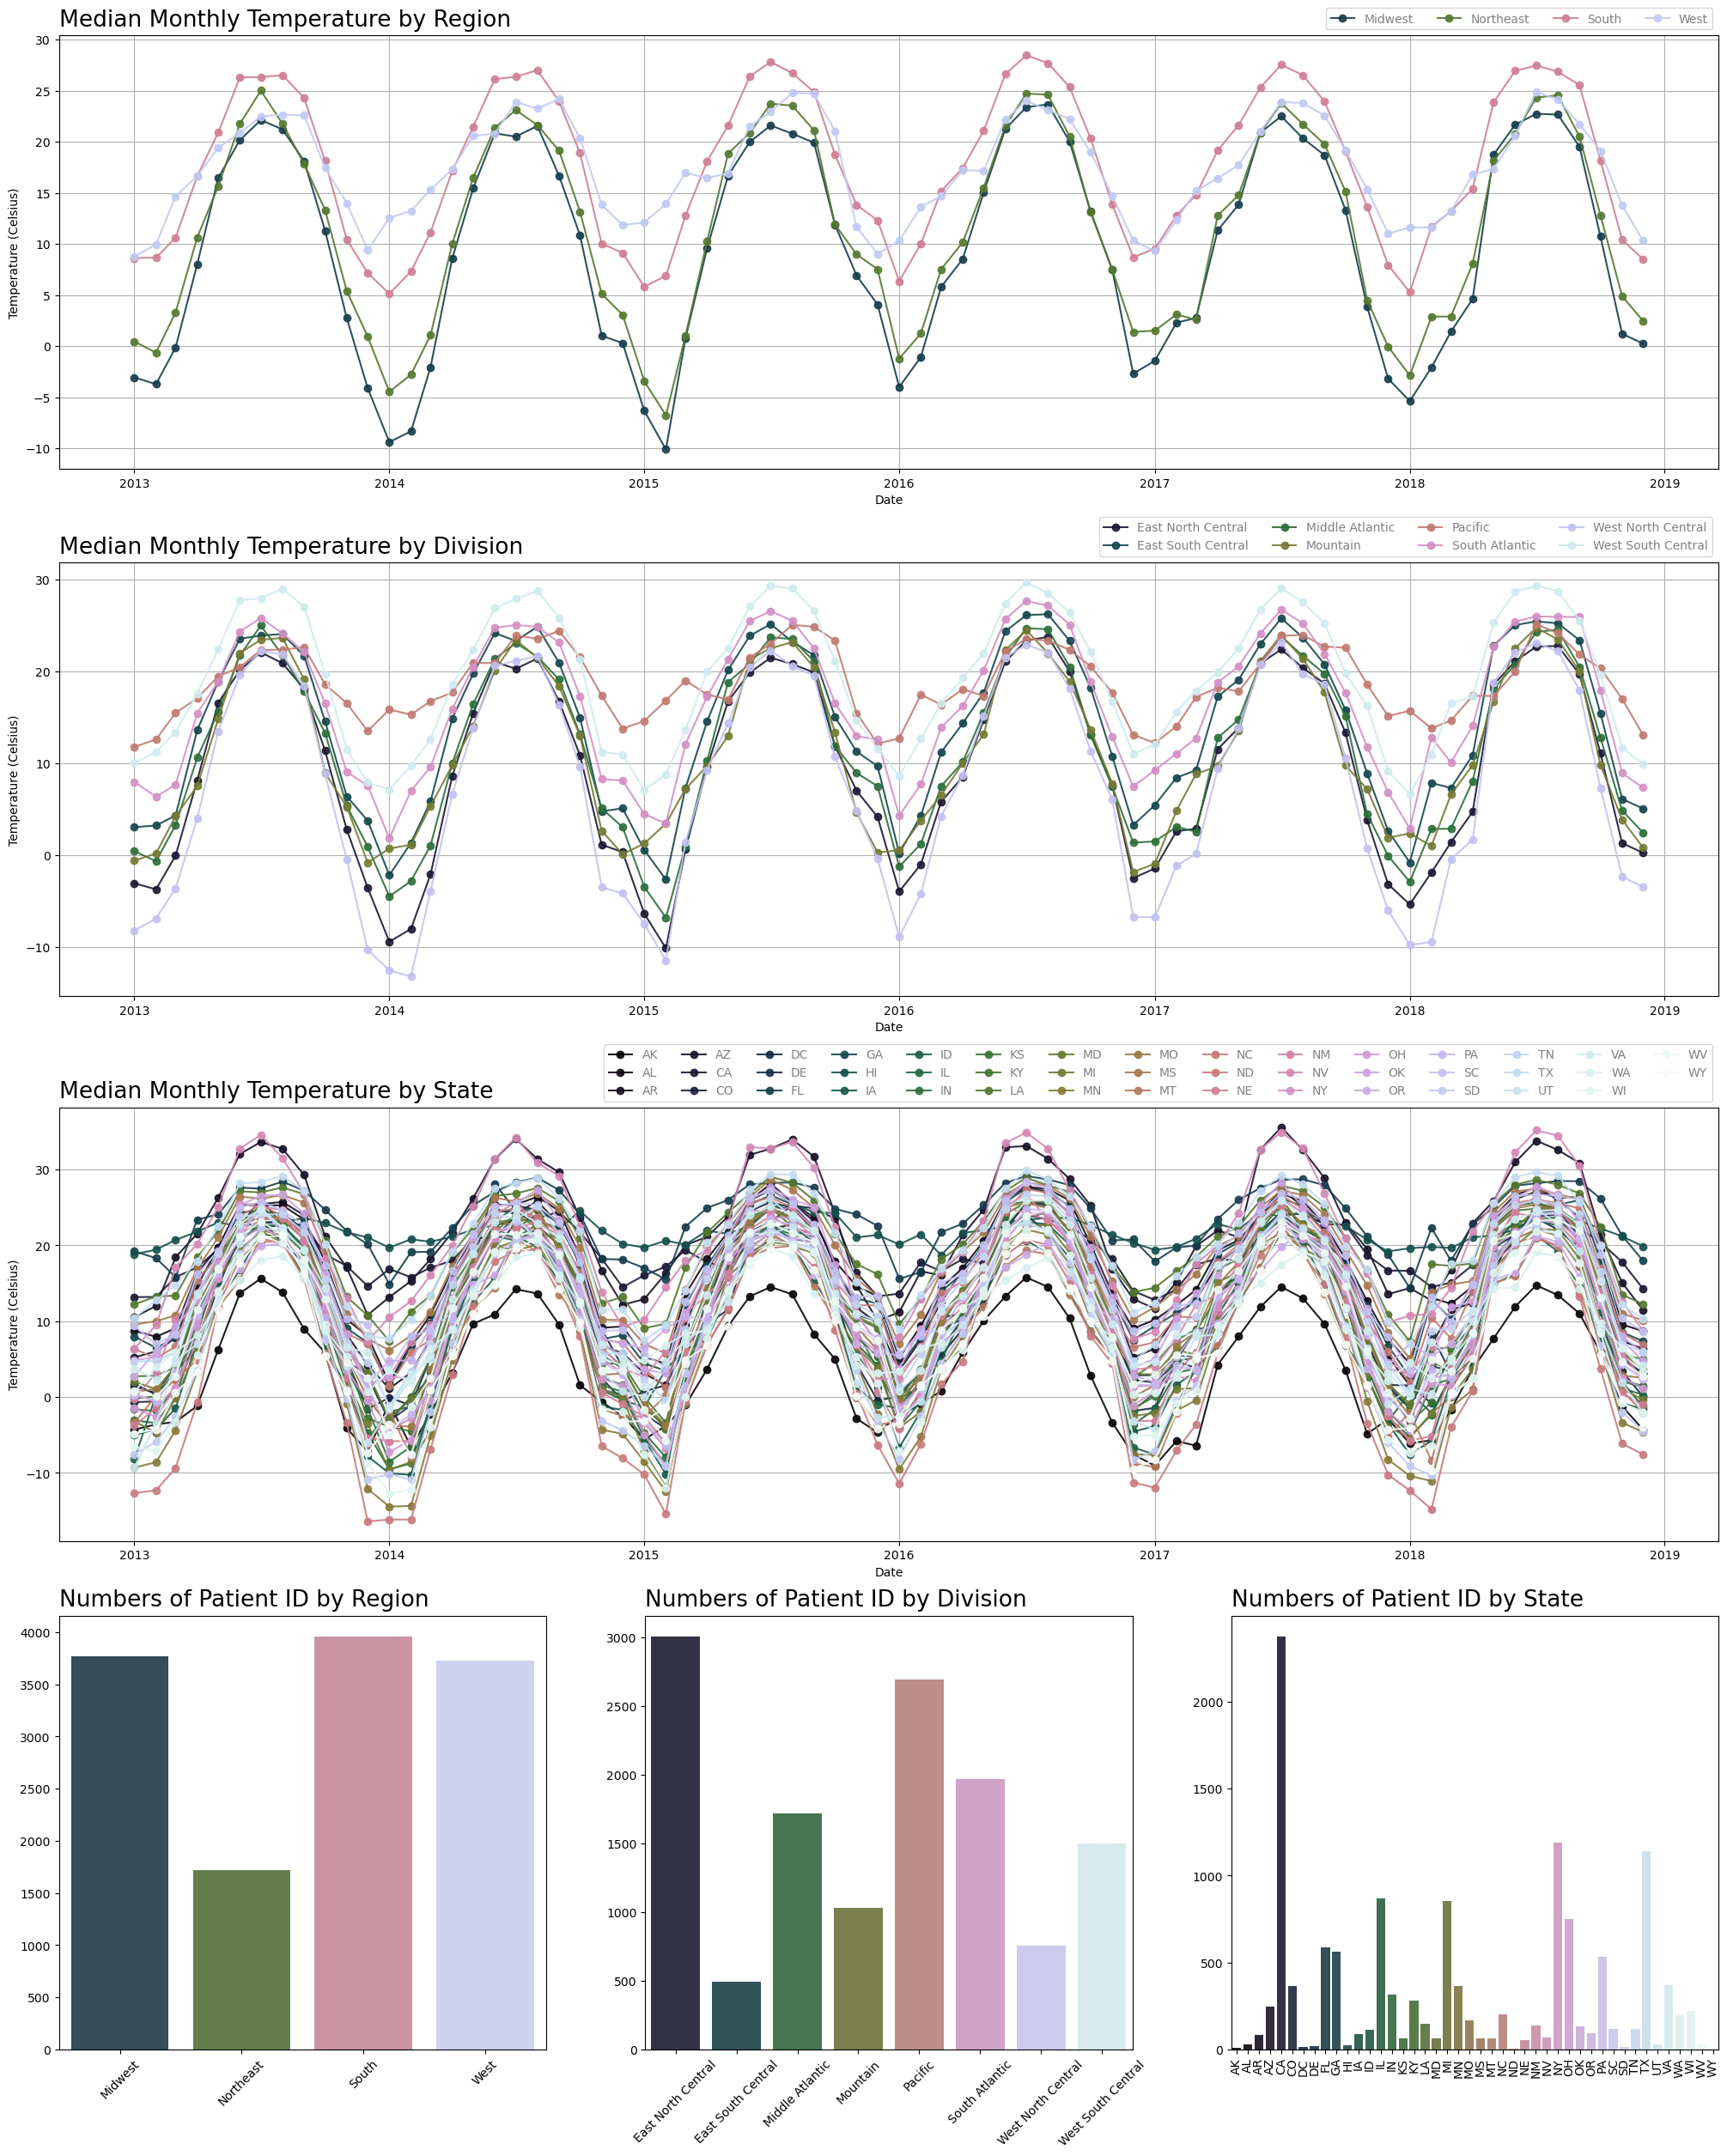

In [471]:
_columns = ["region", "division", "patient_state"]
_grid_dict = {
    "region": ["A", "D"],
    "division": ["B", "E"],
    "patient_state": ["C", "F"]
}
# Plot line plot for weather data and histograms for distribution
fig = plt.figure(figsize=[20, 25], layout="constrained", clear=True)
ax_dict = fig.subplot_mosaic([
    ["A", "A", "A"], 
    ["B", "B", "B"], 
    ["C", "C", "C"], 
    ["D", "E", "F"]
])


for _col in _columns:
    _df_train = (
        df_train[["patient_id", "patient_zip3"]]
        .merge(zip_region_dict[["patient_zip3", _col]], how="left", on="patient_zip3")
        .groupby(by=_col)["patient_id"]
        .count()
        .reset_index()
    )

    _df_weather = (
        weather_cleaned[WEATHER_COL[1:]+[_col]]
        .groupby(by=_col)
        .median()
        .transpose()
        .reset_index()
        .rename(columns={"index":"date_str"})
    )

    # Transform a column name like "average_of_jun_18" into a date format
    dates = []
    for name in _df_weather["date_str"]:
        # Extract month abbreviation and year
        month_abbr, year = name.split('_')[-2:]
        # Map month abbreviation to numeric value
        month_num = dt.datetime.strptime(month_abbr, '%b').month
        # Construct date string
        date_string = f"{month_num:02d}-{"20"+year}"
        # Convert to datetime object
        date_obj = dt.datetime.strptime(date_string, '%m-%Y')
        dates.append(date_obj)

    _df_weather["date"] = dates

    # Set the date as the index
    _df_weather.set_index("date", inplace=True)
    _df_weather = _df_weather.drop(columns=["date_str"])

    # Apply function to convert Fahrenheit to Celsius
    # (32°F − 32) × 5/9 = 0°C
    f_celsius = lambda x: (x-32) * 5/9
    _df_weather = _df_weather.apply(func=f_celsius, result_type='broadcast')
    
    # Colors for visualisation
    palette = sns.color_palette(palette="cubehelix", n_colors=len(_df_weather.columns))
    alpha = 0.9

    # Plots
    ax1 = ax_dict[_grid_dict[_col][0]]
    for i, lab in enumerate(_df_weather.columns):
        ax1.plot(_df_weather.index, _df_weather[lab], marker='o', label=lab, alpha=alpha, color=palette[i])

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Temperature (Celsius)')
    ax1.set_title(
        f'Median Monthly Temperature by {_col.replace("patient_", "").title()}', 
        loc="left", 
        fontdict={"fontsize": 19},
        pad=8.0
    )
    ncol = [4 if len(_df_weather.columns) < 9 else 15]
    ax1.legend(loc='lower right', bbox_to_anchor=(1.0, 1.0), ncol=ncol[0], labelcolor='gray')
    ax1.grid(True)

    # Barplots
    ax2 = ax_dict[_grid_dict[_col][1]]
    sns.barplot(data=_df_train, x=_col, y='patient_id', ax=ax2, alpha=alpha, palette=palette)
    
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title(
        f'Numbers of Patient ID by {_col.replace("patient_", "").title()}', 
        loc="left", 
        fontdict={"fontsize": 19},
        pad=8.0
    )
    rotation = [90 if len(_df_weather.columns) > 8 else 45]
    ax2.xaxis.set_tick_params(rotation=rotation[0], labelsize=10)
    
    display(_df_weather.describe())


The data shows that there is no simple link between the target metric `metastatic_diagnosis_period` and the monthly temperature variables. However, the graphics show that there is a pattern in climate data across different regions, divisions and states. We can use geographic attributes instead of temperatures to incorporate climate aspects into our model. In addition, there is a trend for some regions in climate change that looks like "winter" (Now-Feb) has become warmer. The difference looks huge (about 5&deg;C) when broken down by region.

#### Examination of socio-economic data patterns

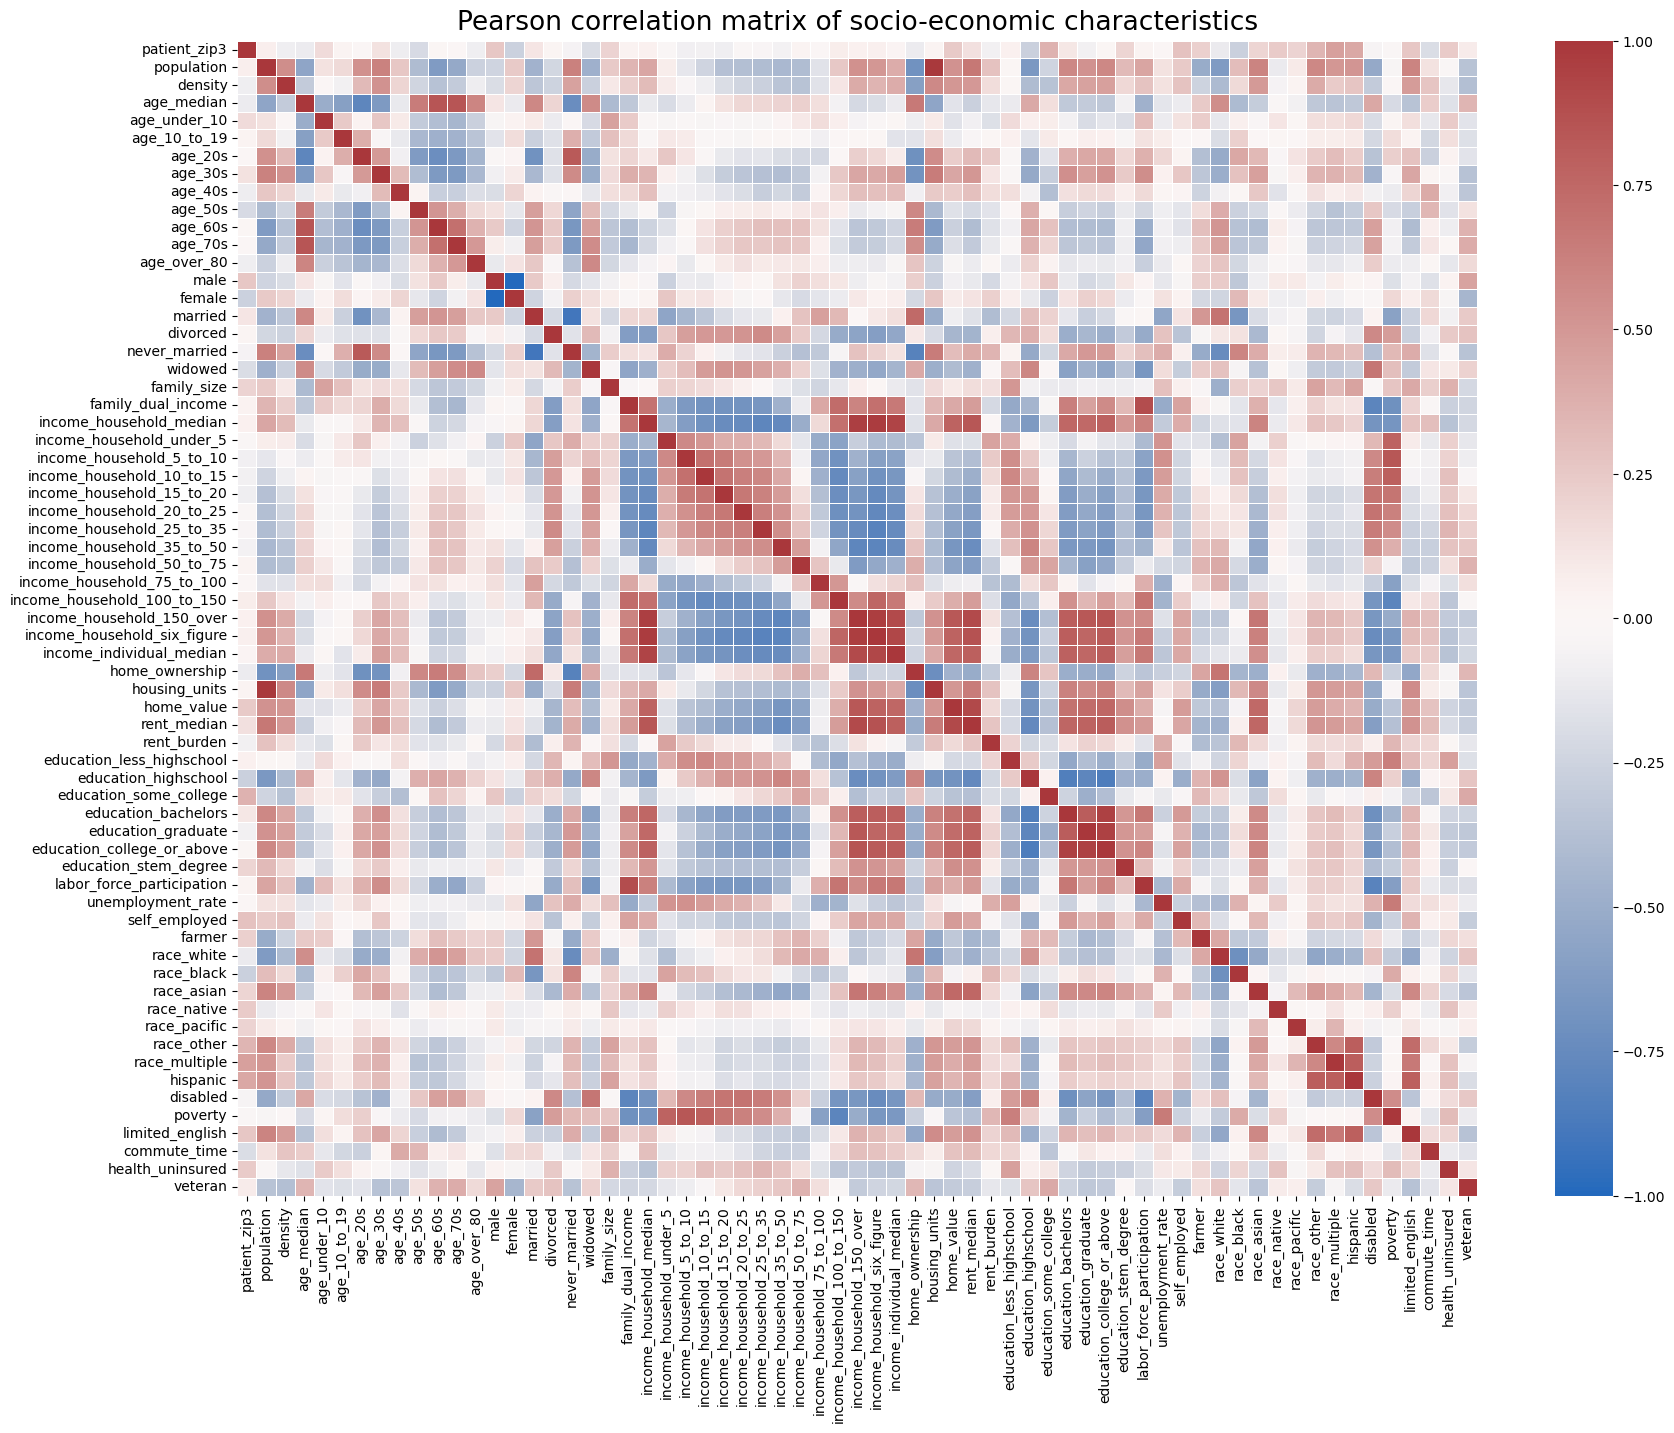

In [472]:
# Calculate correlation
correlation_matrix = social_metrics_dict.corr(method='pearson')

# Plot the correlation matrix
palette = sns.color_palette("vlag", as_cmap=True)

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, linewidth=.4, cmap=palette, vmin=-1, vmax=1)
plt.title(
    "Pearson correlation matrix of socio-economic characteristics", 
    fontdict={"fontsize": 19}, 
    pad=8.0
)
plt.show()

In [473]:
# Normalize numerical and encode categorical features
numerical_features = social_metrics_dict.columns[1:].to_list()

scaler = StandardScaler()
_social_metrics_dict = social_metrics_dict.copy()
_social_metrics_dict[numerical_features] = scaler.fit_transform(_social_metrics_dict[numerical_features])
_social_metrics_dict = pd.get_dummies(social_metrics_dict, columns=["patient_zip3"])
display(_social_metrics_dict.head(3))

population  density  age_median  age_under_10  age_10_to_19  age_20s  \
0     4639.07    72.66       41.50         11.40         13.44    11.42   
1    10875.30   217.91       39.64         11.23         13.72    15.01   
2    18716.73  1019.51       30.37         11.00         18.86    23.11   

   age_30s  age_40s  age_50s  age_60s  age_70s  age_over_80   male  female  \
0    11.45    12.56    13.08    14.26     7.71         4.73  50.02   49.98   
1    12.02    11.58    11.77    12.77     8.52         3.41  51.33   48.67   
2    12.24     9.88     9.12     8.38     4.78         2.62  50.29   49.71   

   married  divorced  never_married  widowed  family_size  family_dual_income  \
0    42.37     14.70          34.76     8.18         3.30               38.83   
1    44.14     13.28          34.62     7.96         3.33               42.57   
2    35.99     12.76          46.65     4.63         3.15               54.23   

   income_household_median  income_household_under_5  \
0                 40643.61                      6.77   
1                 49924.38                      4.59   
2                 48238.92                      6.12   

   income_household_5_to_10  income_household_10_to_15  \
0                      5.02                       9.93   
1                      3.83                       6.58   
2                      4.73                       6.70   

   income_household_15_to_20  income_household_20_to_25  \
0                       7.53                       6.36   
1                       5.27                       5.90   
2                       4.86                       6.21   

   income_household_25_to_35  income_household_35_to_50  \
0                      11.54                      12.60   
1                      13.16                      13.99   
2                      11.19                      13.28   

   income_household_50_to_75  income_household_75_to_100  \
0                      12.70                       11.60   
1                      18.14                       10.65   
2                      16.98                       10.42   

   income_household_100_to_150  income_household_150_over  \
0                         9.53                       6.43   
1                        11.39                       6.49   
2                        11.80                       7.68   

   income_household_six_figure  income_individual_median  home_ownership  \
0                        15.97                  22663.32           74.78   
1                        17.88                  26495.64           67.09   
2                        19.48                  25137.57           47.85   

   housing_units  home_value  rent_median  rent_burden  \
0        1698.43    113973.9       671.07        37.23   
1        4034.71    119537.2       806.92        31.42   
2        7234.27    125587.7       978.00        38.84   

   education_less_highschool  education_highschool  education_some_college  \
0                      21.30                 36.81                   26.95   
1                      15.22                 31.24                   34.65   
2                      15.75                 27.97                   28.53   

   education_bachelors  education_graduate  education_college_or_above  \
0                 9.74                5.21                       14.94   
1                12.87                6.00                       18.88   
2                16.37               11.37                       27.74   

   education_stem_degree  labor_force_participation  unemployment_rate  \
0                  38.47                      49.41               8.08   
1                  36.55                      56.90               8.38   
2                  41.32                      62.04               5.44   

   self_employed  farmer  race_white  race_black  race_asian  race_native  \
0          12.89    4.88       66.51       29.06        0.40         0.37   
1          10.64    1.40       54.08       26.6

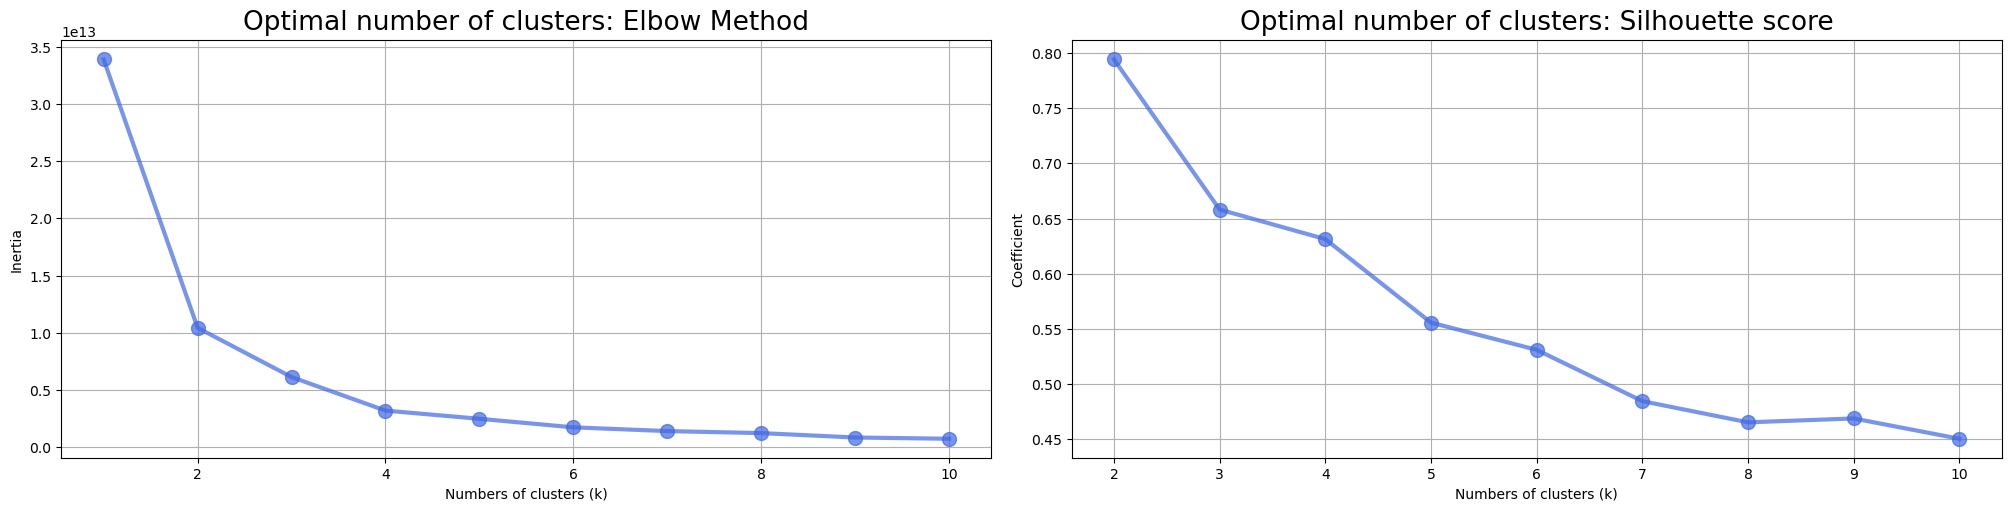

In [474]:
# Try to determine the optimal number of clusters
fig = plt.figure(figsize=[20, 5], layout="constrained", clear=True)
ax_dict = fig.subplot_mosaic([["a", "b"]])

# Elbow method:
wcss_list = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(_social_metrics_dict)
    wcss_list.append(kmeans.inertia_)

ax1 = ax_dict["a"]
ax1.plot(range(1, 11), wcss_list, marker='o', color='royalblue', alpha=0.7, markersize=10, linewidth=3.0)
ax1.set_title(
    'Optimal number of clusters: Elbow Method',
    fontdict={"fontsize": 19},
    pad=8.0
)
ax1.set_xlabel('Numbers of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.grid(True)

# Silhouette score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(_social_metrics_dict)
    score = silhouette_score(_social_metrics_dict, kmeans.labels_)
    silhouette_scores.append(score)

ax2 = ax_dict["b"]
ax2.plot(range(2, 11), silhouette_scores, marker='o', color='royalblue', alpha=0.7, markersize=10, linewidth=3.0)
ax2.set_title(
    'Optimal number of clusters: Silhouette score', 
    fontdict={"fontsize": 19},
    pad=8.0
)
ax2.set_xlabel('Numbers of clusters (k)')
ax2.set_ylabel('Coefficient')
ax2.grid(True)



In [475]:
# Apply KMeans to find clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels_geo = kmeans.fit_predict(_social_metrics_dict)

# Calculate silhouette score to evaluate thecluster's quality
print(f"Numbers of clusters: {n_clusters}")
print(f"Silhouette score: {silhouette_score(_social_metrics_dict, labels_geo):.2f}")

social_metrics_dict['cluster'] = labels_geo
display(social_metrics_dict.groupby(['cluster']).count()[["patient_zip3"]])

Numbers of clusters: 5
Silhouette score: 0.56


patient_zip3
cluster              
0                  41
1                 447
2                  68
3                 191
4                  15

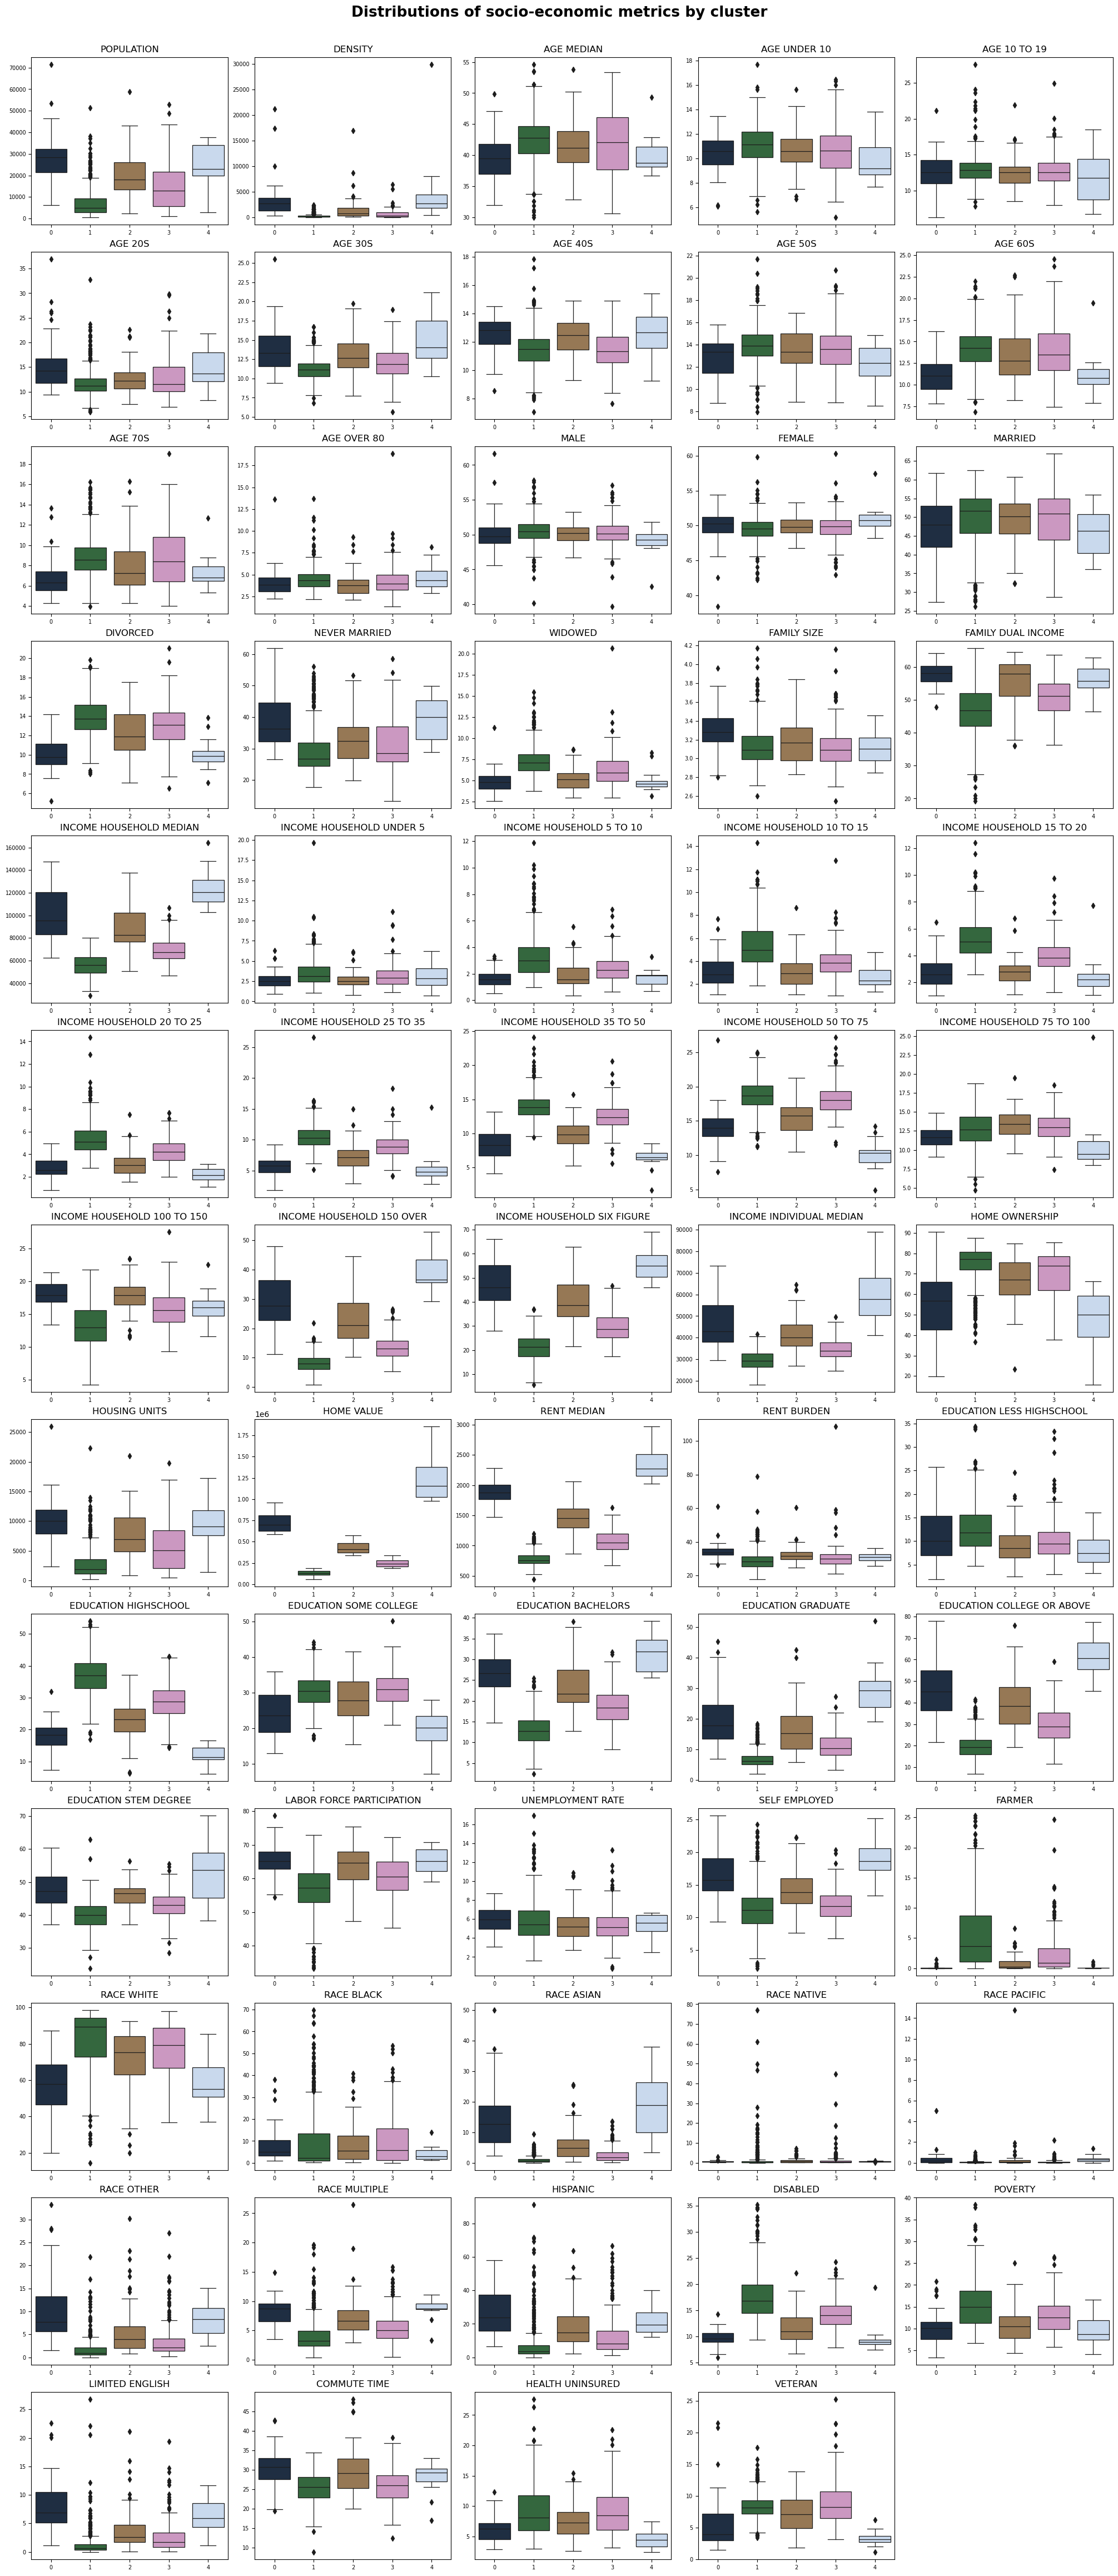

In [476]:
# Potential features for model
columns = [
    "population", "age_median", "income_household_median",
    "rent_median", "education_college_or_above", "disabled", 
    "limited_english", "health_uninsured", "race_white",
]

columns = social_metrics_dict.columns[1:-1]

ncols = 5
nrows = ceil(len(columns)/ncols)
attr = 0

fig = plt.figure(figsize=[20, nrows*3.5], alpha=0.7, layout='constrained')
axes = fig.subplots(nrows, ncols)
fig.suptitle(
    'Distributions of socio-economic metrics by cluster', 
    fontsize=19, 
    y=1.015, 
    fontweight='bold'
)

for row in range(0, nrows):
    for col in range(0, ncols):
        if attr == len(columns):
            fig.delaxes(axes[row, col])
            continue
        
        sns.boxplot(
            x="cluster", 
            y=columns[attr], 
            data=social_metrics_dict, 
            orient='v', 
            ax=axes[row, col],
            palette="cubehelix",
            linewidth=.9
        )

        axes[row, col].set_title(
            f"{columns[attr].replace("_", " ").upper()}",
            fontdict={"fontsize": 12},
            pad=6.0
        )
        axes[row, col].set_xlabel("")
        axes[row, col].set_ylabel("")
        axes[row, col].tick_params(labelsize=7)

        attr+=1


#### Individual patient data review

In [477]:
col = [
    "patient_id", "patient_zip3", "patient_race", "payer_type", "patient_age", 
    "bmi", "breast_cancer_diagnosis_code", "metastatic_cancer_diagnosis_code"
]

personal_test_df = df_test[col].copy()
personal_train_df = df_train[col].copy()

personal_df = pd.concat([personal_test_df, personal_train_df])
print("Testing dataset: ")
display(personal_test_df.describe())
print("Training dataset: ")
display(personal_train_df.describe())

Testing dataset: 


patient_id  patient_zip3  patient_age          bmi
count    5646.000000   5646.000000  5646.000000  1705.000000
mean   549581.847680    569.824655    58.921537    29.142798
std    260549.557126    276.824893    13.326813     5.612167
min    100401.000000    100.000000    18.000000    16.000000
25%    325189.750000    330.000000    50.000000    24.840000
50%    551142.500000    554.000000    59.000000    28.340000
75%    773004.000000    836.000000    66.000000    33.140000
max    999846.000000    997.000000    91.000000    43.700000

Training dataset: 


patient_id  patient_zip3   patient_age          bmi
count   13173.000000  13173.000000  13173.000000  4102.000000
mean   555441.784939    568.530859     59.271313    29.168808
std    259476.503094    275.758485     13.218883     5.752820
min    100043.000000    100.000000     18.000000    15.000000
25%    335100.000000    330.000000     50.000000    24.825000
50%    555769.000000    557.000000     59.000000    28.580000
75%    780967.000000    832.000000     67.000000    33.000000
max    999982.000000    995.000000     91.000000    97.000000

In [478]:
df = {
    "training": personal_train_df[["bmi", "patient_age"]],
    "testing": personal_test_df[["bmi", "patient_age"]]
}

print("Correlation between BMI and age:\n")
for key in df:
    for method in ["pearson", "spearman"]:
        correlation = df[key].bmi.corr(df[key].patient_age, method=method)
        print(f"{method.title()} correlation coefficient in {key} data: {correlation:.3f}")
    print('')

Correlation between BMI and age:

Pearson correlation coefficient in training data: -0.064
Spearman correlation coefficient in training data: -0.031

Pearson correlation coefficient in testing data: -0.056
Spearman correlation coefficient in testing data: -0.033



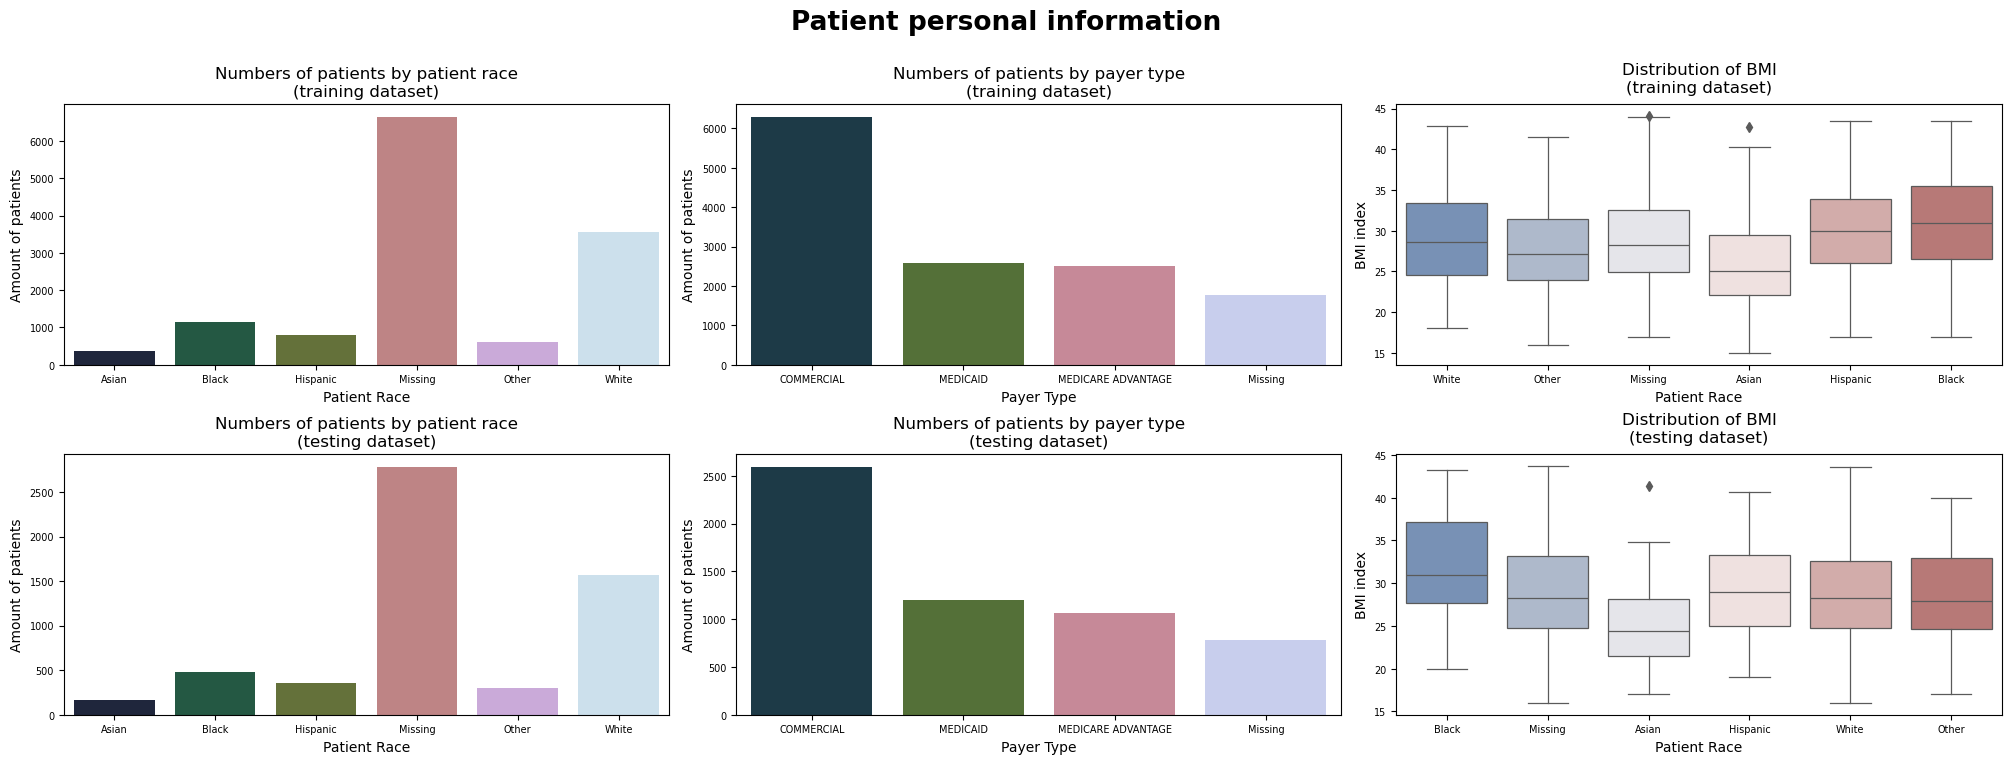

In [479]:
df = {
    "training": personal_train_df.fillna(value={"payer_type": "Missing", "patient_race": "Missing"}),
    "testing": personal_test_df.fillna(value={"payer_type": "Missing", "patient_race": "Missing"})
}
columns = ["patient_race", "payer_type"]

fig = plt.figure(figsize=[20, 7], alpha=0.7, layout='constrained')
axes = fig.subplots(2, 3)
fig.suptitle(
    'Patient personal information', 
    fontsize=19, 
    y=1.07, 
    fontweight='bold'
)


irow = 0
for key in df:
    icol = 0
    for col in columns:
        _df = df[key].groupby([col]).count().reset_index()
        sns.barplot(x=_df[col], y=_df["patient_id"], palette="cubehelix", ax=axes[irow, icol])
        
        axes[irow, icol].set_ylabel('Amount of patients')
        axes[irow, icol].set_xlabel(f'{col.replace('_', " ").title()}')
        axes[irow, icol].set_title(
            f"Numbers of patients by {col.replace("_", " ")}\n({key} dataset)",
            fontdict={"fontsize": 12},
            pad=6.0
        )
        axes[irow, icol].tick_params(labelsize=7)

        icol+=1
    
    sns.boxplot(
        x="patient_race",
        y="bmi", 
        data=df[key].query("bmi < 50"), 
        orient='v', 
        ax=axes[irow, 2],
        palette="vlag",
        linewidth=.9
    )

    axes[irow, 2].set_ylabel('BMI index')
    axes[irow, 2].set_xlabel('Patient Race')
    axes[irow, 2].set_title(
            f"Distribution of BMI\n({key} dataset)",
            fontdict={"fontsize": 12},
            pad=9.0
        )
    axes[irow, 2].tick_params(labelsize=7)

    irow+=1

In [480]:
# df["training"].groupby(["breast_cancer_diagnosis_code"]).count()[["patient_id"]].sort_values(["patient_id"])
# df["testing"].groupby(["breast_cancer_diagnosis_code"]).count()[["patient_id"]].sort_values(["patient_id"])

# df["testing"].groupby(["metastatic_cancer_diagnosis_code"]).count()[["patient_id"]].sort_values(["patient_id"])
# df["training"].groupby(["metastatic_cancer_diagnosis_code"]).count()[["patient_id"]].sort_values(["patient_id"])

#### Structuring and pre-cleaning: key takeaways

**New dictionaries have been created with cleaned data:**
- `zip_region_dict` with general geo information per postcode (state, region, division).
- `social_metrics_dict` with general socio-economic and demographic data per zip code (age, income, education, race and others). In addition, a `cluster` column has been added which divides the data into 5 clusters with similar characteristics. 

**Results of the examination of climate data:**
- The relationship between the target metric `metastatic_diagnosis_period` and climate data was not found, neither linear (Pearson correlation) nor non-linear (Spearman correlation).
- The following patterns are most evident when looking at monthly average temperature indicators in different regions and divisions:
    - The greatest differences are observed in the autumn-winter period (November-February): temperatures fall below zero in the Midwest and Northeast,
    - In the spring-summer period, the hottest areas are in the southern and western regions,
    - Climate changes are mainly observed in regions with relatively cold winters; differences between 2014-2015 and 2016-209 can reach +5&deg;C. However, for the southern regions, the differences are not so visible and the temperature in summer remains stable.  

In order to take into the model the possible influence of climatic conditions, we can use categorical variables of the region or division without additional data on the temperature in them, and also check the behaviour of the model by adding data for the coldest winter months (January-February), since these months have the highest climate change signals.

**Results of the examination of the socio-economic and demographic data:**
- All postcodes can be divided into 4-5 groups, which differ in the following parameters `population`, `age_median`, `household_income_median`, `rent_median`, `education_college_or_above`, `self_employed`, `disabled`, `limited_english`, `health_uninsured`.
- Relationships between groups of characteristics:
    - Population, density and number of housing units are correlated,
    - Age Median can represent all age attributes,
    - Income and education groups have a strong linear correlation,
    - Race groups may depend on population size,
    - Unemployment rate depends on education and English level,
    - Gender, commuting time and veteran attributes have the lowest correlations with other metrics.

**Results of the examination of the socio-economic and demographic data:**
- Race and BMI have a lot of missing data and it looks like it is impossible to fill them in with median or mode because it could cause bias in the model. At the same time, we can't just drop these characteristics because we have a limited amount of personal data. One of the strategies could be to transform the data into 3-4 specific categories such as "low", "normal", "high", "unknown". For BMI it can be impossible because of 70% data is missing.
- Missing data in `payer_type` does not look random and compares well with the distribution of `health_uninsured` (6-12% depending on geographical data), in high level of probability it is patients without insurance.
- For `breast_cancer_diagnosis_code` and `metastatic_cancer_diagnosis_code` the large part of the data is concentrated around a few codes and for some codes there are only single observations, but the distributions for the test and training datasets are similar.
    - Top-5 of breast cancer codes: 1749, C50912, C50911, C50919, C50411.
    - Top-5 of metastatic cancer codes: C773, C7951, C779, C7981, C7800.


### Cleaning data

#### Ctrategy for cleaning data
1) Drop the columns `metastatic_first_novel_treatment_type`, `metastatic_first_novel_treatment`, and bmi because they have over 70% missing data. With such a high percentage of missing values, any imputation method would introduce significant uncertainty and potential bias into the model. Also, drop the column `patient_gender`.
2) Create new categories for `patient_race` such as "white", "other", and "unknown".
3) Fill the missing values in `payer_type` with "no insurance".
4) Possible strategies for handling climate data:
    - Use `division` as a more relevant attribute related to weather patterns (as clusters).
    - Use `division` and the temperature of January per year (winter months demonstrate more visible changes in temperature year-by-year).
    - There isn't any correlation between the target metrics and climate data, so not using climate data should not affect the results.
5) Remove rows from the training dataset:
    - With the 772 postcode because it has missing data (0.04%).
    - With male-specific codes C50421, C50922, C50221, C50122, and the unspecified code C509.
6) Select the following columns related to social, economic, and demographic information: `population`, `age_median`, `household_income_median`, `rent_median`, `education_college_or_above`, `self_employed`, `disabled`, `limited_english`, `health_uninsured`, and `commute_time`. Drop the others.
7) Validate the resulting datasets.


In [481]:
TARGET = ["metastatic_diagnosis_period"]

patient_features = [
    # Key for joining dictionaries
    "patient_zip3",
    # Individual patient data
    "patient_id", "patient_race", "payer_type", "patient_age", 
    "breast_cancer_diagnosis_code", "metastatic_cancer_diagnosis_code",  
]

social_features = [
    # Key for joining dictionaries
    "patient_zip3",
    # Social, economic, and demographic information
    "population", "age_median", "income_household_median", "rent_median", 
    "education_college_or_above", "self_employed", "disabled", 
    "limited_english", "health_uninsured", "commute_time"
]

geographical_features = [
    "patient_zip3", "region_num", "division_num", "division"
]


def cleaned_df(df, patient_features, social_features, geographical_features, target=None):
    if target != None:
        patient_features = patient_features + target
    new_df = (
        df[patient_features]
        .merge(breast_cancer_diagnosis_dict, on="breast_cancer_diagnosis_code")
        .merge(zip_region_dict[geographical_features], on="patient_zip3")
        .merge(social_metrics_dict[social_features], on="patient_zip3")
        .merge(weather_dict, on="division_num")
    )

    new_df["payer_type"] = new_df["payer_type"].fillna("no insurance").str.lower()

    new_df["patient_race"] = (
        new_df["patient_race"]
        .fillna("uknown")
        .apply(lambda x: x.lower() if x == "White" or x == "uknown" else "other")
    )

    display(new_df.info())

    return new_df

print("Training dataset:\n")
cleaned_train_df = cleaned_df(
    df=df_train, 
    patient_features=patient_features, 
    social_features=social_features, 
    geographical_features=geographical_features, 
    target=TARGET
)

print("Testing dataset:\n")
cleaned_test_df = cleaned_df(
    df=df_test, 
    patient_features=patient_features, 
    social_features=social_features, 
    geographical_features=geographical_features
)

Training dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13160 entries, 0 to 13159
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_zip3                      13160 non-null  int64  
 1   patient_id                        13160 non-null  int64  
 2   patient_race                      13160 non-null  object 
 3   payer_type                        13160 non-null  object 
 4   patient_age                       13160 non-null  int64  
 5   breast_cancer_diagnosis_code      13160 non-null  object 
 6   metastatic_cancer_diagnosis_code  13160 non-null  object 
 7   metastatic_diagnosis_period       13160 non-null  int64  
 8   breast_cancer_diagnosis_desc      13160 non-null  object 
 9   region_num                        13160 non-null  int64  
 10  division_num                      13160 non-null  int64  
 11  division                          13160 non-null

None

Testing dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5646 entries, 0 to 5645
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_zip3                      5646 non-null   int64  
 1   patient_id                        5646 non-null   int64  
 2   patient_race                      5646 non-null   object 
 3   payer_type                        5646 non-null   object 
 4   patient_age                       5646 non-null   int64  
 5   breast_cancer_diagnosis_code      5646 non-null   object 
 6   metastatic_cancer_diagnosis_code  5646 non-null   object 
 7   breast_cancer_diagnosis_desc      5646 non-null   object 
 8   region_num                        5646 non-null   int64  
 9   division_num                      5646 non-null   int64  
 10  division                          5646 non-null   object 
 11  population                        5646 non-null   f

None

#### Check the correlation between the categorical, numeric and target columns

Pairs with correlation between -1 and -0.1 or 0.1 and 1:

Correlation between patient_race_num and patient_age: 0.1075
Correlation between patient_race_num and population: -0.2089
Correlation between patient_race_num and age_median: 0.1731
Correlation between patient_race_num and rent_median: -0.1676
Correlation between patient_race_num and self_employed: -0.1919
Correlation between patient_race_num and disabled: 0.1081
Correlation between patient_race_num and limited_english: -0.2212
Correlation between patient_race_num and health_uninsured: -0.1170
Correlation between patient_race_num and commute_time: -0.1122
Correlation between payer_type_num and patient_age: 0.2848
Correlation between patient_race_num and metastatic_diagnosis_period: 0.1763
Correlation between payer_type_num and metastatic_diagnosis_period: 0.1818
Correlation between breast_cancer_diagnosis_code_num and metastatic_diagnosis_period: 0.1957
Correlation between metastatic_cancer_diagnosis_code_num and metastatic_diag

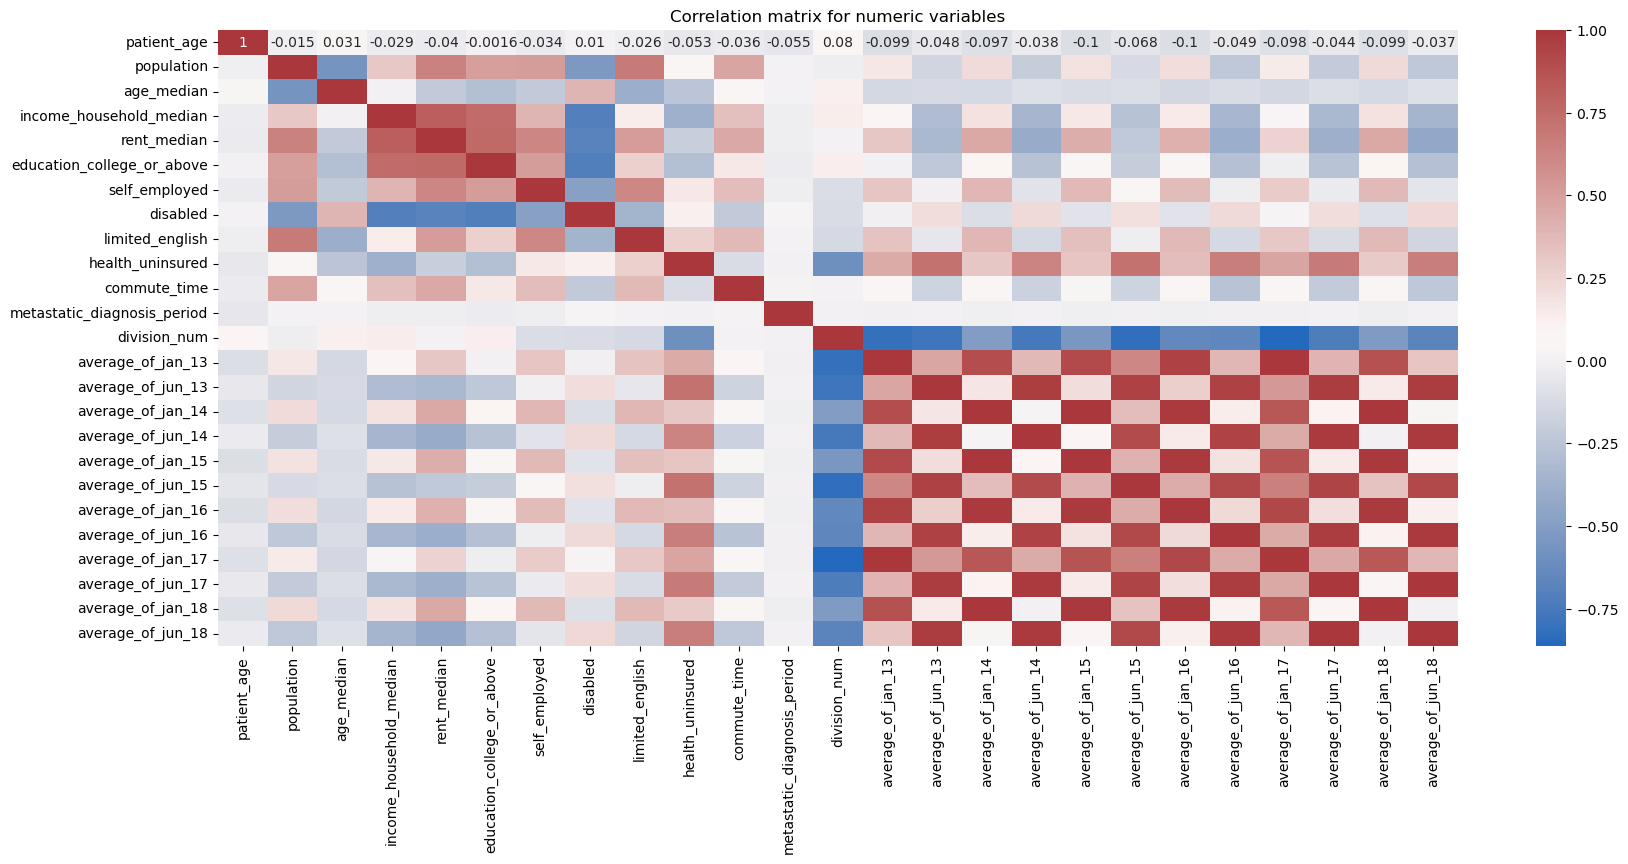

In [482]:
# Columns by type
categorical_columns = ["patient_race", "payer_type", "breast_cancer_diagnosis_code", "metastatic_cancer_diagnosis_code"]
numerical_columns = [
    "patient_age", "population", "age_median", "income_household_median", "rent_median", "education_college_or_above", 
    "self_employed", "disabled", "limited_english", "health_uninsured", "commute_time"
]

# Collect correlations
correlation_results = {}

# Convert the categorical variables into numerical format using Label Encoding
label_encoder = LabelEncoder()

encoded_df = cleaned_train_df.copy()
for col in categorical_columns:
    _col = f"{col}_num"
    encoded_df[_col] = label_encoder.fit_transform(encoded_df[col].astype(str))


# Calculate correlation between categorical and numeric variables using Cramér's V test
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))


for cat_col in categorical_columns:
    cat_col = f"{cat_col}_num"
    for num_col in numerical_columns:
        correlation = pointbiserialr(encoded_df[cat_col], encoded_df[num_col])[0]
        correlation_results[(cat_col, num_col)] = correlation

for num_col in numerical_columns:
    for cat_col in categorical_columns:
        cat_col = f"{cat_col}_num"
        correlation = cramers_v(encoded_df[cat_col], encoded_df[TARGET[0]])
        correlation_results[(cat_col, TARGET[0])] = correlation


# Print or visualize the correlation results for categorical-numeric and categorical-target pairs
print("Pairs with correlation between -1 and -0.1 or 0.1 and 1:\n")
for key, value in correlation_results.items():
        if -1<value<-0.1 or 0.1<value<1:
            print(f"Correlation between {key[0]} and {key[1]}: {value:.4f}")


# Calculate Pearson correlation for numeric-numeric variables
numeric_corr = encoded_df[numerical_columns + TARGET + [i for i in weather_dict.columns if i.find("avg")]].corr(method='pearson')
# Visualize the numeric correlations
plt.figure(figsize=(20, 8))
sns.heatmap(numeric_corr, annot=True, cmap='vlag')
plt.title('Correlation matrix for numeric variables')
plt.show()


## Attribute selection and final categorical data transformation



In [486]:
selected_features = [
    "patient_id", 
    # there is a correlation with target metric (about 0.2):
    "patient_race", "payer_type", "breast_cancer_diagnosis_code", "metastatic_cancer_diagnosis_code",
    # there is linear relationship with weather:
    "division",
    # other features:
    "patient_age", "age_median", "rent_median", "self_employed", 
    "disabled", "limited_english", "health_uninsured", "commute_time"
]

In [493]:
# Re-check correlation (should not be above 0.75)
numeric_corr[[i for i in numeric_corr.columns if i in selected_features]].drop(index=[i for i in numeric_corr.columns if i not in selected_features])

patient_age  age_median  rent_median  self_employed  \
patient_age          1.000000    0.030508    -0.040277      -0.034021   
age_median           0.030508    1.000000    -0.215322      -0.216487   
rent_median         -0.040277   -0.215322     1.000000       0.618955   
self_employed       -0.034021   -0.216487     0.618955       1.000000   
disabled             0.010176    0.395557    -0.685147      -0.489229   
limited_english     -0.025653   -0.389868     0.513963       0.612503   
health_uninsured    -0.053319   -0.247494    -0.200228       0.156191   
commute_time        -0.036340    0.044981     0.447177       0.356441   

                  disabled  limited_english  health_uninsured  commute_time  
patient_age       0.010176        -0.025653         -0.053319     -0.036340  
age_median        0.395557        -0.389868         -0.247494      0.044981  
rent_median      -0.685147         0.513963         -0.200228      0.447177  
self_employed    -0.489229         0.612503          0.156191      0.356441  
disabled          1.000000        -0.358406          0.121949     -0.220476  
limited_english  -0.358406         1.000000          0.267398      0.374990  
health_uninsured  0.121949         0.267398          1.000000     -0.113318  
commute_time     -0.220476         0.374990         -0.113318      1.000000

In [508]:
# Final encoding
def encode_columns(df, selected_features, target=None):
    if target != None:
        selected_features = (selected_features + target)

    new_df = df[selected_features]
    
    # one-hot encoding
    new_df = pd.get_dummies(new_df, columns=["patient_race", "payer_type", "division"])

    # numerical feature scaling (label_encoder = LabelEncoder())
    for col in ["breast_cancer_diagnosis_code", "metastatic_cancer_diagnosis_code"]:
        new_df[col] = label_encoder.fit_transform(new_df[col].astype(str))
    
    # numerical feature normalisation (scaler = StandardScaler())
    num_col = [
        "patient_age", "age_median", "rent_median", "self_employed", 
        "disabled", "limited_english", "health_uninsured", "commute_time"
    ]
    new_df[num_col] = scaler.fit_transform(new_df[num_col])

    # rename columns in pythonic style
    new_df.columns = [i.lower().replace(" ", "_") for i in new_df.columns]
    
    return new_df


train_model_df = encode_columns(cleaned_train_df, selected_features=selected_features, target=TARGET)
test_model_df = encode_columns(cleaned_test_df, selected_features=selected_features)

print("Final training dataset: ")
display(train_model_df.head())
display(train_model_df.describe())
display(train_model_df.info())

print("\n\nFinal testing dataset: ")
display(test_model_df.head())
display(test_model_df.describe())
display(test_model_df.info())


Final training dataset: 


patient_id  breast_cancer_diagnosis_code  metastatic_cancer_diagnosis_code  \
0      268700                            40                                 3   
1      484983                            26                                 3   
2      277055                             7                                 3   
3      320055                            39                                 3   
4      190386                             6                                30   

   patient_age  age_median  rent_median  self_employed  disabled  \
0    -1.533432    0.505885    -1.373511      -0.402698  2.385691   
1    -0.323312    0.745086    -1.380020      -1.179178  1.822921   
2    -0.020782   -1.063873     0.936592       0.007685 -0.160300   
3    -0.020782   -0.971680     0.982106       2.375506 -0.411923   
4     0.886808    0.306551     0.937058       0.397401 -0.395689   

   limited_english  health_uninsured  commute_time  \
0        -0.832443         -0.108859     -0.516297   
1        -0.830351         -0.379858     -0.337293   
2         0.037716         -0.106461      1.789118   
3         2.162914          0.437934      0.538056   
4         0.238522         -0.473388     -0.884140   

   metastatic_diagnosis_period  patient_race_other  patient_race_uknown  \
0                          191               False                 True   
1                           33               False                False   
2                          157               False                 True   
3                          146                True                False   
4                          286               False                 True   

   patient_race_white  payer_type_commercial  payer_type_medicaid  \
0               False                   True                False   
1                True                  False                False   
2               False                   True                False   
3               False                  False                 True   
4               False                   True                False   

   payer_type_medicare_advantage  payer_type_no_insurance  \
0                          False                    False   
1                          False                     True   
2                          False                    False   
3                          False                    False   
4                          False                    False   

   division_east_north_central  division_east_south_central  \
0                        False                        False   
1                         True                        False   
2                        False                        False   
3                        False                        False   
4                        False                        False   

   division_middle_atlantic  division_mountain  division_pacific  \
0                     False              False             False   
1                     False              False             False   
2                     False              False              True   
3                     False              False              True   
4                     False              False              True   

   division_south_atlantic  division_west_north_central  \
0                    False                        False   
1                    False                        False   
2                    False                        False   
3                    False                        False   
4                    False                        False   

   division_west_south_central  
0                         True  
1                        False  
2                        False  
3                        False  
4                        False

patient_id  breast_cancer_diagnosis_code  \
count   13160.000000                  13160.000000   
mean   555557.411854                     26.577964   
std    259478.753929                     13.799940   
min    100043.000000                      0.000000   
25%    335176.500000                     14.000000   
50%    555958.000000                     28.000000   
75%    781062.250000                     40.000000   
max    999982.000000                     41.000000   

       metastatic_cancer_diagnosis_code   patient_age    age_median  \
count                      13160.000000  1.316000e+04  1.316000e+04   
mean                          11.906763  2.310884e-16  6.198352e-16   
std                           13.085114  1.000038e+00  1.000038e+00   
min                            0.000000 -3.121714e+00 -2.621172e+00   
25%                            3.000000 -7.014742e-01 -8.371298e-01   
50%                            3.000000 -2.078170e-02  2.249933e-02   
75%                           25.000000  5.842783e-01  5.937167e-01   
max                           42.000000  2.399458e+00  3.493408e+00   

        rent_median  self_employed      disabled  limited_english  \
count  1.316000e+04   1.316000e+04  1.316000e+04     1.316000e+04   
mean   1.371412e-16   4.084541e-16 -7.221511e-17    -5.885194e-17   
std    1.000038e+00   1.000038e+00  1.000038e+00     1.000038e+00   
min   -1.823728e+00  -3.225188e+00 -2.005534e+00    -9.202956e-01   
25%   -7.960612e-01  -6.477468e-01 -8.367055e-01    -7.236731e-01   
50%   -1.743338e-01  -1.340300e-01 -1.251268e-01    -3.450700e-01   
75%    5.787330e-01   5.538781e-01  6.162137e-01     3.305586e-01   
max    4.047702e+00   3.647988e+00  5.881355e+00     4.677172e+00   

       health_uninsured  commute_time  metastatic_diagnosis_period  
count      1.316000e+04  1.316000e+04                 13160.000000  
mean       5.183290e-17  2.435067e-16                    96.521884  
std        1.000038e+00  1.000038e+00                   108.986823  
min       -1.456657e+00 -3.051860e+00                     0.000000  
25%       -6.988207e-01 -6.107167e-01                     3.000000  
50%       -2.767344e-01 -5.206671e-02                    44.000000  
75%        4.523237e-01  5.380565e-01                   181.000000  
max        4.570063e+00  3.943067e+00                   365.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13160 entries, 0 to 13159
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_id                        13160 non-null  int64  
 1   breast_cancer_diagnosis_code      13160 non-null  int64  
 2   metastatic_cancer_diagnosis_code  13160 non-null  int64  
 3   patient_age                       13160 non-null  float64
 4   age_median                        13160 non-null  float64
 5   rent_median                       13160 non-null  float64
 6   self_employed                     13160 non-null  float64
 7   disabled                          13160 non-null  float64
 8   limited_english                   13160 non-null  float64
 9   health_uninsured                  13160 non-null  float64
 10  commute_time                      13160 non-null  float64
 11  metastatic_diagnosis_period       13160 non-null  int64  
 12  pati

None



Final testing dataset: 


patient_id  breast_cancer_diagnosis_code  metastatic_cancer_diagnosis_code  \
0      730681                             5                                34   
1      334212                            39                                 3   
2      571362                             1                                 3   
3      907331                             6                                28   
4      208382                            25                                18   

   patient_age  age_median  rent_median  self_employed  disabled  \
0    -0.294285    0.248681    -1.298513      -0.105883  1.852246   
1     0.080931   -0.218301    -0.983915      -0.761477  1.176134   
2    -0.369329   -2.545680    -0.587731      -0.659496 -0.030632   
3     0.306061    0.956686    -1.047807       0.106821  2.038109   
4     0.231018   -0.208259     1.580323      -0.152503 -0.997661   

   limited_english  health_uninsured  commute_time  patient_race_other  \
0        -0.816126         -0.116420      0.327292               False   
1        -0.498253          1.176372     -0.415824                True   
2        -0.221397          1.438747     -2.498921               False   
3        -0.818176          0.510894     -0.071936               False   
4         0.114933         -0.800980      0.637582                True   

   patient_race_uknown  patient_race_white  payer_type_commercial  \
0                 True               False                   True   
1                False               False                  False   
2                 True               False                   True   
3                 True               False                   True   
4                False               False                  False   

   payer_type_medicaid  payer_type_medicare_advantage  \
0                False                          False   
1                False                          False   
2                False                          False   
3                False                          False   
4                False                          False   

   payer_type_no_insurance  division_east_north_central  \
0                    False                        False   
1                     True                        False   
2                    False                        False   
3                    False                        False   
4                     True                        False   

   division_east_south_central  division_middle_atlantic  division_mountain  \
0                        False                     False              False   
1                        False                     False              False   
2                        False                     False              False   
3                         True                     False              False   
4                        False                     False              False   

   division_pacific  division_south_atlantic  division_west_north_central  \
0             False                    False                        False   
1             False                     True                        False   
2             False                    False                        False   
3             False                    False                        False   
4              True                    False                        False   

   division_west_south_central  
0                         True  
1                        False  
2                         True  
3                        False  
4                        False

patient_id  breast_cancer_diagnosis_code  \
count    5646.000000                   5646.000000   
mean   549581.847680                     25.720687   
std    260549.557126                     13.547270   
min    100401.000000                      0.000000   
25%    325189.750000                     10.000000   
50%    551142.500000                     27.000000   
75%    773004.000000                     38.000000   
max    999846.000000                     40.000000   

       metastatic_cancer_diagnosis_code   patient_age    age_median  \
count                       5646.000000  5.646000e+03  5.646000e+03   
mean                          11.251328  2.554732e-16  5.411502e-17   
std                           11.732993  1.000089e+00  1.000089e+00   
min                            0.000000 -3.070889e+00 -2.631042e+00   
25%                            3.000000 -6.695020e-01 -8.484760e-01   
50%                            3.000000  5.888098e-03  3.276438e-02   
75%                           24.000000  5.311915e-01  6.102154e-01   
max                           37.000000  2.407275e+00  3.530109e+00   

        rent_median  self_employed      disabled  limited_english  \
count  5.646000e+03   5.646000e+03  5.646000e+03     5.646000e+03   
mean   3.146222e-17   3.964239e-16 -7.771168e-17    -4.908106e-17   
std    1.000089e+00   1.000089e+00  1.000089e+00     1.000089e+00   
min   -1.814167e+00  -3.034204e+00 -1.854249e+00    -9.289191e-01   
25%   -8.060629e-01  -6.594961e-01 -8.252655e-01    -7.361449e-01   
50%   -1.558620e-01  -1.525034e-01 -1.329914e-01    -3.649519e-01   
75%    6.359256e-01   5.759345e-01  6.239309e-01     4.148608e-01   
max    4.014298e+00   3.580012e+00  5.846964e+00     4.558994e+00   

       health_uninsured  commute_time  
count      5.646000e+03  5.646000e+03  
mean      -1.459847e-16 -5.002493e-16  
std        1.000089e+00  1.000089e+00  
min       -1.485540e+00 -3.785539e+00  
25%       -6.793334e-01 -6.169202e-01  
50%       -2.857712e-01 -5.217189e-02  
75%        5.061237e-01  5.249288e-01  
max        4.508532e+00  3.946029e+00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5646 entries, 0 to 5645
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_id                        5646 non-null   int64  
 1   breast_cancer_diagnosis_code      5646 non-null   int64  
 2   metastatic_cancer_diagnosis_code  5646 non-null   int64  
 3   patient_age                       5646 non-null   float64
 4   age_median                        5646 non-null   float64
 5   rent_median                       5646 non-null   float64
 6   self_employed                     5646 non-null   float64
 7   disabled                          5646 non-null   float64
 8   limited_english                   5646 non-null   float64
 9   health_uninsured                  5646 non-null   float64
 10  commute_time                      5646 non-null   float64
 11  patient_race_other                5646 non-null   bool   
 12  patien

None

### Prediction model